In [0]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import cv2
from torch.nn.parameter import Parameter
import torch.optim as optim
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# (optional) create the labels and save as CSV
import glob
files = glob.glob('gdrive/My Drive/images/train/*/*/*/*')
data_list = []
for f in files:
  labels = f.split('/')
  chain_id = labels[-4]
  hotel_id = labels[-3]
  d_source = labels[-2]
  image_id = labels[-1]
  data_list.append([f, chain_id, hotel_id, d_source, image_id])
data_df = pd.DataFrame(data=data_list, columns=['urls', 'chain_id', 'hotel_id','d_source', 'image_id'])
data_df.head()

KeyboardInterrupt: ignored

In [3]:
data_df = pd.read_csv('gdrive/My Drive/images/train_labels_df.csv')
data_df.head()

,Unnamed: 0,urls,chain_id,hotel_id,d_source,image_id
0,0,gdrive/My Drive/images/train/3/9115/traffickca...,3,9115,traffickcam,3868556.jpg
1,1,gdrive/My Drive/images/train/3/16412/traffickc...,3,16412,traffickcam,2682883.jpg
2,2,gdrive/My Drive/images/train/3/16412/traffickc...,3,16412,traffickcam,2682880.jpg
3,3,gdrive/My Drive/images/train/3/16412/traffickc...,3,16412,traffickcam,2686795.jpg
4,4,gdrive/My Drive/images/train/3/16810/traffickc...,3,16810,traffickcam,3902562.jpg


In [4]:
# convert label id to indices from 0 to 24
chain_id = pd.unique(data_df['chain_id'])
one_hot_idx = dict(zip(chain_id, np.arange(0,25)))
label_idx = one_hot_idx.get(3)
print(label_idx)

0


In [5]:
num_samples = data_df.shape[0]
num_samples

5574

In [0]:
class Hotel50KDataset:
    def __init__(self, path_to_csv, label_loc, transform=None):
        self.data_df = pd.read_csv(path_to_csv)
        self.label_loc = label_loc
        self.transform = transform
    def __len__(self):
        return len(self.data_df)
    def __getitem__(self, idx):
        img_name = self.data_df.iloc[idx, 1]
        image = Image.open(img_name)
        image = image.resize((120,120), Image.ANTIALIAS)
        label_class = self.data_df.iloc[idx, label_loc]
        label = one_hot_idx.get(label_class)
        if self.transform:
            image = self.transform(image)
        #print(image.shape)
        return (image, label)

In [0]:
path_to_csv = 'gdrive/My Drive/images/train_labels_df.csv'
label_loc = 2
full_dataset = Hotel50KDataset(path_to_csv, label_loc, 
                             transform=transforms.Compose([
                           transforms.RandomRotation(35),
                           transforms.RandomAffine(1.0),
                           transforms.ToTensor()]))

In [0]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

In [0]:
bs = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs,
                                             shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = bs,
                                             shuffle=True, num_workers=4)

In [0]:
def train(model, criterion, train_loader, val_loader, optimizer, epoch, batch_size):
    # training phase
    running_train_loss = 0.0
    running_train_corrects = 0
    # set model state to train
    model.train()
    with torch.set_grad_enabled(True):
        for batch_idx, sample in enumerate(train_loader):
            print('Epoch {} : [{} / {}]'.format(epoch, batch_idx, len(train_loader)))
            data, target = sample
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            _, preds = torch.max(output, 1)
            # back-prop
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * data.size(0)
            running_train_corrects += torch.sum(preds == target.data)
    epoch_train_loss = running_train_loss / (batch_size * len(train_loader))
    epoch_train_acc = 100*float(running_train_corrects) / (batch_size * len(train_loader))
    print('Epoch {} train completed: train loss = {}, train acc = {} %'.format(epoch, epoch_train_loss, epoch_train_acc))
    # validation phase
    running_val_loss = 0.0
    running_val_corrects = 0
    # set model state to eval
    model.eval()
    print('Epoch {} evaluating'.format(epoch))
    with torch.no_grad():
        for batch_idx, sample in enumerate(val_loader):
            data, target = sample
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            _, preds = torch.max(output, 1)
            running_val_loss += loss.item() * data.size(0)
            running_val_corrects += torch.sum(preds == target.data)
    epoch_val_loss = running_val_loss / (batch_size * len(val_loader))
    epoch_val_acc = 100*float(running_val_corrects) / (batch_size * len(val_loader))
    print('Epoch {} val completed: val loss = {}, val acc = {} %'.format(epoch, epoch_val_loss, epoch_val_acc))
    return epoch_train_loss, epoch_val_loss
    
            

In [11]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 25)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 81617709.10it/s]


In [0]:
len(train_loader)

70

Epoch 1 : [0 / 70]
Epoch 1 : [1 / 70]
Epoch 1 : [2 / 70]
Epoch 1 : [3 / 70]
Epoch 1 : [4 / 70]
Epoch 1 : [5 / 70]
Epoch 1 : [6 / 70]
Epoch 1 : [7 / 70]
Epoch 1 : [8 / 70]
Epoch 1 : [9 / 70]
Epoch 1 : [10 / 70]
Epoch 1 : [11 / 70]
Epoch 1 : [12 / 70]
Epoch 1 : [13 / 70]
Epoch 1 : [14 / 70]
Epoch 1 : [15 / 70]
Epoch 1 : [16 / 70]
Epoch 1 : [17 / 70]
Epoch 1 : [18 / 70]
Epoch 1 : [19 / 70]
Epoch 1 : [20 / 70]
Epoch 1 : [21 / 70]
Epoch 1 : [22 / 70]
Epoch 1 : [23 / 70]
Epoch 1 : [24 / 70]
Epoch 1 : [25 / 70]
Epoch 1 : [26 / 70]
Epoch 1 : [27 / 70]
Epoch 1 : [28 / 70]
Epoch 1 : [29 / 70]
Epoch 1 : [30 / 70]
Epoch 1 : [31 / 70]
Epoch 1 : [32 / 70]
Epoch 1 : [33 / 70]
Epoch 1 : [34 / 70]
Epoch 1 : [35 / 70]
Epoch 1 : [36 / 70]
Epoch 1 : [37 / 70]
Epoch 1 : [38 / 70]
Epoch 1 : [39 / 70]
Epoch 1 : [40 / 70]
Epoch 1 : [41 / 70]
Epoch 1 : [42 / 70]
Epoch 1 : [43 / 70]
Epoch 1 : [44 / 70]
Epoch 1 : [45 / 70]
Epoch 1 : [46 / 70]
Epoch 1 : [47 / 70]
Epoch 1 : [48 / 70]
Epoch 1 : [49 / 70]
Epoch 1 : 

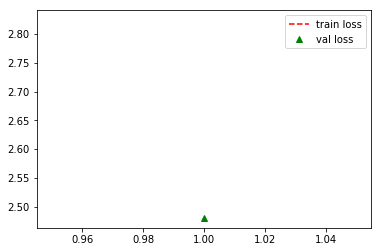

Epoch 2 : [0 / 70]
Epoch 2 : [1 / 70]
Epoch 2 : [2 / 70]
Epoch 2 : [3 / 70]
Epoch 2 : [4 / 70]
Epoch 2 : [5 / 70]
Epoch 2 : [6 / 70]
Epoch 2 : [7 / 70]
Epoch 2 : [8 / 70]
Epoch 2 : [9 / 70]
Epoch 2 : [10 / 70]
Epoch 2 : [11 / 70]
Epoch 2 : [12 / 70]
Epoch 2 : [13 / 70]
Epoch 2 : [14 / 70]
Epoch 2 : [15 / 70]
Epoch 2 : [16 / 70]
Epoch 2 : [17 / 70]
Epoch 2 : [18 / 70]
Epoch 2 : [19 / 70]
Epoch 2 : [20 / 70]
Epoch 2 : [21 / 70]
Epoch 2 : [22 / 70]
Epoch 2 : [23 / 70]
Epoch 2 : [24 / 70]
Epoch 2 : [25 / 70]
Epoch 2 : [26 / 70]
Epoch 2 : [27 / 70]
Epoch 2 : [28 / 70]
Epoch 2 : [29 / 70]
Epoch 2 : [30 / 70]
Epoch 2 : [31 / 70]
Epoch 2 : [32 / 70]
Epoch 2 : [33 / 70]
Epoch 2 : [34 / 70]
Epoch 2 : [35 / 70]
Epoch 2 : [36 / 70]
Epoch 2 : [37 / 70]
Epoch 2 : [38 / 70]
Epoch 2 : [39 / 70]
Epoch 2 : [40 / 70]
Epoch 2 : [41 / 70]
Epoch 2 : [42 / 70]
Epoch 2 : [43 / 70]
Epoch 2 : [44 / 70]
Epoch 2 : [45 / 70]
Epoch 2 : [46 / 70]
Epoch 2 : [47 / 70]
Epoch 2 : [48 / 70]
Epoch 2 : [49 / 70]
Epoch 2 : 

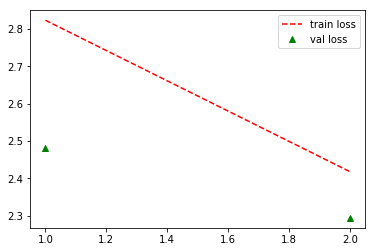

Epoch 3 : [0 / 70]
Epoch 3 : [1 / 70]
Epoch 3 : [2 / 70]
Epoch 3 : [3 / 70]
Epoch 3 : [4 / 70]
Epoch 3 : [5 / 70]
Epoch 3 : [6 / 70]
Epoch 3 : [7 / 70]
Epoch 3 : [8 / 70]
Epoch 3 : [9 / 70]
Epoch 3 : [10 / 70]
Epoch 3 : [11 / 70]
Epoch 3 : [12 / 70]
Epoch 3 : [13 / 70]
Epoch 3 : [14 / 70]
Epoch 3 : [15 / 70]
Epoch 3 : [16 / 70]
Epoch 3 : [17 / 70]
Epoch 3 : [18 / 70]
Epoch 3 : [19 / 70]
Epoch 3 : [20 / 70]
Epoch 3 : [21 / 70]
Epoch 3 : [22 / 70]
Epoch 3 : [23 / 70]
Epoch 3 : [24 / 70]
Epoch 3 : [25 / 70]
Epoch 3 : [26 / 70]
Epoch 3 : [27 / 70]
Epoch 3 : [28 / 70]
Epoch 3 : [29 / 70]
Epoch 3 : [30 / 70]
Epoch 3 : [31 / 70]
Epoch 3 : [32 / 70]
Epoch 3 : [33 / 70]
Epoch 3 : [34 / 70]
Epoch 3 : [35 / 70]
Epoch 3 : [36 / 70]
Epoch 3 : [37 / 70]
Epoch 3 : [38 / 70]
Epoch 3 : [39 / 70]
Epoch 3 : [40 / 70]
Epoch 3 : [41 / 70]
Epoch 3 : [42 / 70]
Epoch 3 : [43 / 70]
Epoch 3 : [44 / 70]
Epoch 3 : [45 / 70]
Epoch 3 : [46 / 70]
Epoch 3 : [47 / 70]
Epoch 3 : [48 / 70]
Epoch 3 : [49 / 70]
Epoch 3 : 

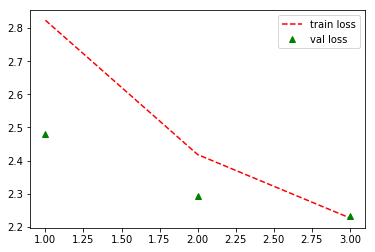

Epoch 4 : [0 / 70]
Epoch 4 : [1 / 70]
Epoch 4 : [2 / 70]
Epoch 4 : [3 / 70]
Epoch 4 : [4 / 70]
Epoch 4 : [5 / 70]
Epoch 4 : [6 / 70]
Epoch 4 : [7 / 70]
Epoch 4 : [8 / 70]
Epoch 4 : [9 / 70]
Epoch 4 : [10 / 70]
Epoch 4 : [11 / 70]
Epoch 4 : [12 / 70]
Epoch 4 : [13 / 70]
Epoch 4 : [14 / 70]
Epoch 4 : [15 / 70]
Epoch 4 : [16 / 70]
Epoch 4 : [17 / 70]
Epoch 4 : [18 / 70]
Epoch 4 : [19 / 70]
Epoch 4 : [20 / 70]
Epoch 4 : [21 / 70]
Epoch 4 : [22 / 70]
Epoch 4 : [23 / 70]
Epoch 4 : [24 / 70]
Epoch 4 : [25 / 70]
Epoch 4 : [26 / 70]
Epoch 4 : [27 / 70]
Epoch 4 : [28 / 70]
Epoch 4 : [29 / 70]
Epoch 4 : [30 / 70]
Epoch 4 : [31 / 70]
Epoch 4 : [32 / 70]
Epoch 4 : [33 / 70]
Epoch 4 : [34 / 70]
Epoch 4 : [35 / 70]
Epoch 4 : [36 / 70]
Epoch 4 : [37 / 70]
Epoch 4 : [38 / 70]
Epoch 4 : [39 / 70]
Epoch 4 : [40 / 70]
Epoch 4 : [41 / 70]
Epoch 4 : [42 / 70]
Epoch 4 : [43 / 70]
Epoch 4 : [44 / 70]
Epoch 4 : [45 / 70]
Epoch 4 : [46 / 70]
Epoch 4 : [47 / 70]
Epoch 4 : [48 / 70]
Epoch 4 : [49 / 70]
Epoch 4 : 

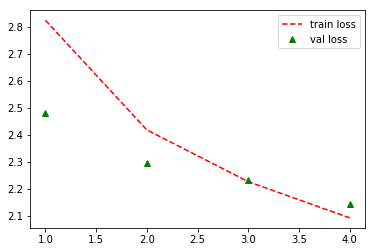

Epoch 5 : [0 / 70]
Epoch 5 : [1 / 70]
Epoch 5 : [2 / 70]
Epoch 5 : [3 / 70]
Epoch 5 : [4 / 70]
Epoch 5 : [5 / 70]
Epoch 5 : [6 / 70]
Epoch 5 : [7 / 70]
Epoch 5 : [8 / 70]
Epoch 5 : [9 / 70]
Epoch 5 : [10 / 70]
Epoch 5 : [11 / 70]
Epoch 5 : [12 / 70]
Epoch 5 : [13 / 70]
Epoch 5 : [14 / 70]
Epoch 5 : [15 / 70]
Epoch 5 : [16 / 70]
Epoch 5 : [17 / 70]
Epoch 5 : [18 / 70]
Epoch 5 : [19 / 70]
Epoch 5 : [20 / 70]
Epoch 5 : [21 / 70]
Epoch 5 : [22 / 70]
Epoch 5 : [23 / 70]
Epoch 5 : [24 / 70]
Epoch 5 : [25 / 70]
Epoch 5 : [26 / 70]
Epoch 5 : [27 / 70]
Epoch 5 : [28 / 70]
Epoch 5 : [29 / 70]
Epoch 5 : [30 / 70]
Epoch 5 : [31 / 70]
Epoch 5 : [32 / 70]
Epoch 5 : [33 / 70]
Epoch 5 : [34 / 70]
Epoch 5 : [35 / 70]
Epoch 5 : [36 / 70]
Epoch 5 : [37 / 70]
Epoch 5 : [38 / 70]
Epoch 5 : [39 / 70]
Epoch 5 : [40 / 70]
Epoch 5 : [41 / 70]
Epoch 5 : [42 / 70]
Epoch 5 : [43 / 70]
Epoch 5 : [44 / 70]
Epoch 5 : [45 / 70]
Epoch 5 : [46 / 70]
Epoch 5 : [47 / 70]
Epoch 5 : [48 / 70]
Epoch 5 : [49 / 70]
Epoch 5 : 

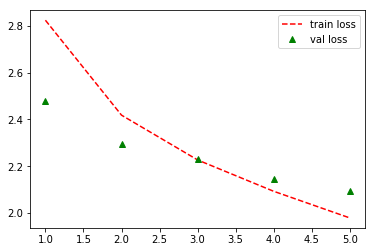

Epoch 6 : [0 / 70]
Epoch 6 : [1 / 70]
Epoch 6 : [2 / 70]
Epoch 6 : [3 / 70]
Epoch 6 : [4 / 70]
Epoch 6 : [5 / 70]
Epoch 6 : [6 / 70]
Epoch 6 : [7 / 70]
Epoch 6 : [8 / 70]
Epoch 6 : [9 / 70]
Epoch 6 : [10 / 70]
Epoch 6 : [11 / 70]
Epoch 6 : [12 / 70]
Epoch 6 : [13 / 70]
Epoch 6 : [14 / 70]
Epoch 6 : [15 / 70]
Epoch 6 : [16 / 70]
Epoch 6 : [17 / 70]
Epoch 6 : [18 / 70]
Epoch 6 : [19 / 70]
Epoch 6 : [20 / 70]
Epoch 6 : [21 / 70]
Epoch 6 : [22 / 70]
Epoch 6 : [23 / 70]
Epoch 6 : [24 / 70]
Epoch 6 : [25 / 70]
Epoch 6 : [26 / 70]
Epoch 6 : [27 / 70]
Epoch 6 : [28 / 70]
Epoch 6 : [29 / 70]
Epoch 6 : [30 / 70]
Epoch 6 : [31 / 70]
Epoch 6 : [32 / 70]
Epoch 6 : [33 / 70]
Epoch 6 : [34 / 70]
Epoch 6 : [35 / 70]
Epoch 6 : [36 / 70]
Epoch 6 : [37 / 70]
Epoch 6 : [38 / 70]
Epoch 6 : [39 / 70]
Epoch 6 : [40 / 70]
Epoch 6 : [41 / 70]
Epoch 6 : [42 / 70]
Epoch 6 : [43 / 70]
Epoch 6 : [44 / 70]
Epoch 6 : [45 / 70]
Epoch 6 : [46 / 70]
Epoch 6 : [47 / 70]
Epoch 6 : [48 / 70]
Epoch 6 : [49 / 70]
Epoch 6 : 

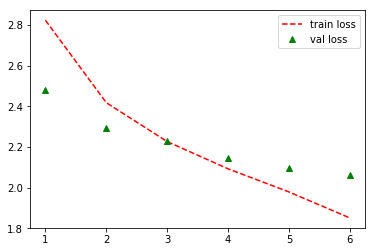

Epoch 7 : [0 / 70]
Epoch 7 : [1 / 70]
Epoch 7 : [2 / 70]
Epoch 7 : [3 / 70]
Epoch 7 : [4 / 70]
Epoch 7 : [5 / 70]
Epoch 7 : [6 / 70]
Epoch 7 : [7 / 70]
Epoch 7 : [8 / 70]
Epoch 7 : [9 / 70]
Epoch 7 : [10 / 70]
Epoch 7 : [11 / 70]
Epoch 7 : [12 / 70]
Epoch 7 : [13 / 70]
Epoch 7 : [14 / 70]
Epoch 7 : [15 / 70]
Epoch 7 : [16 / 70]
Epoch 7 : [17 / 70]
Epoch 7 : [18 / 70]
Epoch 7 : [19 / 70]
Epoch 7 : [20 / 70]
Epoch 7 : [21 / 70]
Epoch 7 : [22 / 70]
Epoch 7 : [23 / 70]
Epoch 7 : [24 / 70]
Epoch 7 : [25 / 70]
Epoch 7 : [26 / 70]
Epoch 7 : [27 / 70]
Epoch 7 : [28 / 70]
Epoch 7 : [29 / 70]
Epoch 7 : [30 / 70]
Epoch 7 : [31 / 70]
Epoch 7 : [32 / 70]
Epoch 7 : [33 / 70]
Epoch 7 : [34 / 70]
Epoch 7 : [35 / 70]
Epoch 7 : [36 / 70]
Epoch 7 : [37 / 70]
Epoch 7 : [38 / 70]
Epoch 7 : [39 / 70]
Epoch 7 : [40 / 70]
Epoch 7 : [41 / 70]
Epoch 7 : [42 / 70]
Epoch 7 : [43 / 70]
Epoch 7 : [44 / 70]
Epoch 7 : [45 / 70]
Epoch 7 : [46 / 70]
Epoch 7 : [47 / 70]
Epoch 7 : [48 / 70]
Epoch 7 : [49 / 70]
Epoch 7 : 

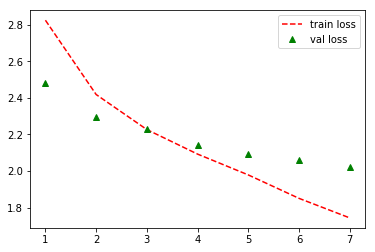

Epoch 8 : [0 / 70]
Epoch 8 : [1 / 70]
Epoch 8 : [2 / 70]
Epoch 8 : [3 / 70]
Epoch 8 : [4 / 70]
Epoch 8 : [5 / 70]
Epoch 8 : [6 / 70]
Epoch 8 : [7 / 70]
Epoch 8 : [8 / 70]
Epoch 8 : [9 / 70]
Epoch 8 : [10 / 70]
Epoch 8 : [11 / 70]
Epoch 8 : [12 / 70]
Epoch 8 : [13 / 70]
Epoch 8 : [14 / 70]
Epoch 8 : [15 / 70]
Epoch 8 : [16 / 70]
Epoch 8 : [17 / 70]
Epoch 8 : [18 / 70]
Epoch 8 : [19 / 70]
Epoch 8 : [20 / 70]
Epoch 8 : [21 / 70]
Epoch 8 : [22 / 70]
Epoch 8 : [23 / 70]
Epoch 8 : [24 / 70]
Epoch 8 : [25 / 70]
Epoch 8 : [26 / 70]
Epoch 8 : [27 / 70]
Epoch 8 : [28 / 70]
Epoch 8 : [29 / 70]
Epoch 8 : [30 / 70]
Epoch 8 : [31 / 70]
Epoch 8 : [32 / 70]
Epoch 8 : [33 / 70]
Epoch 8 : [34 / 70]
Epoch 8 : [35 / 70]
Epoch 8 : [36 / 70]
Epoch 8 : [37 / 70]
Epoch 8 : [38 / 70]
Epoch 8 : [39 / 70]
Epoch 8 : [40 / 70]
Epoch 8 : [41 / 70]
Epoch 8 : [42 / 70]
Epoch 8 : [43 / 70]
Epoch 8 : [44 / 70]
Epoch 8 : [45 / 70]
Epoch 8 : [46 / 70]
Epoch 8 : [47 / 70]
Epoch 8 : [48 / 70]
Epoch 8 : [49 / 70]
Epoch 8 : 

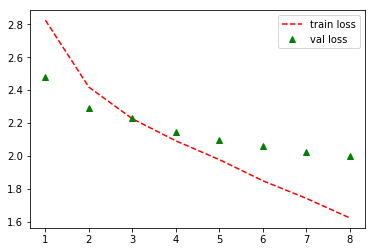

Epoch 9 : [0 / 70]
Epoch 9 : [1 / 70]
Epoch 9 : [2 / 70]
Epoch 9 : [3 / 70]
Epoch 9 : [4 / 70]
Epoch 9 : [5 / 70]
Epoch 9 : [6 / 70]
Epoch 9 : [7 / 70]
Epoch 9 : [8 / 70]
Epoch 9 : [9 / 70]
Epoch 9 : [10 / 70]
Epoch 9 : [11 / 70]
Epoch 9 : [12 / 70]
Epoch 9 : [13 / 70]
Epoch 9 : [14 / 70]
Epoch 9 : [15 / 70]
Epoch 9 : [16 / 70]
Epoch 9 : [17 / 70]
Epoch 9 : [18 / 70]
Epoch 9 : [19 / 70]
Epoch 9 : [20 / 70]
Epoch 9 : [21 / 70]
Epoch 9 : [22 / 70]
Epoch 9 : [23 / 70]
Epoch 9 : [24 / 70]
Epoch 9 : [25 / 70]
Epoch 9 : [26 / 70]
Epoch 9 : [27 / 70]
Epoch 9 : [28 / 70]
Epoch 9 : [29 / 70]
Epoch 9 : [30 / 70]
Epoch 9 : [31 / 70]
Epoch 9 : [32 / 70]
Epoch 9 : [33 / 70]
Epoch 9 : [34 / 70]
Epoch 9 : [35 / 70]
Epoch 9 : [36 / 70]
Epoch 9 : [37 / 70]
Epoch 9 : [38 / 70]
Epoch 9 : [39 / 70]
Epoch 9 : [40 / 70]
Epoch 9 : [41 / 70]
Epoch 9 : [42 / 70]
Epoch 9 : [43 / 70]
Epoch 9 : [44 / 70]
Epoch 9 : [45 / 70]
Epoch 9 : [46 / 70]
Epoch 9 : [47 / 70]
Epoch 9 : [48 / 70]
Epoch 9 : [49 / 70]
Epoch 9 : 

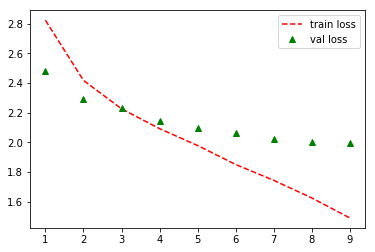

Epoch 10 : [0 / 70]
Epoch 10 : [1 / 70]
Epoch 10 : [2 / 70]
Epoch 10 : [3 / 70]
Epoch 10 : [4 / 70]
Epoch 10 : [5 / 70]
Epoch 10 : [6 / 70]
Epoch 10 : [7 / 70]
Epoch 10 : [8 / 70]
Epoch 10 : [9 / 70]
Epoch 10 : [10 / 70]
Epoch 10 : [11 / 70]
Epoch 10 : [12 / 70]
Epoch 10 : [13 / 70]
Epoch 10 : [14 / 70]
Epoch 10 : [15 / 70]
Epoch 10 : [16 / 70]
Epoch 10 : [17 / 70]
Epoch 10 : [18 / 70]
Epoch 10 : [19 / 70]
Epoch 10 : [20 / 70]
Epoch 10 : [21 / 70]
Epoch 10 : [22 / 70]
Epoch 10 : [23 / 70]
Epoch 10 : [24 / 70]
Epoch 10 : [25 / 70]
Epoch 10 : [26 / 70]
Epoch 10 : [27 / 70]
Epoch 10 : [28 / 70]
Epoch 10 : [29 / 70]
Epoch 10 : [30 / 70]
Epoch 10 : [31 / 70]
Epoch 10 : [32 / 70]
Epoch 10 : [33 / 70]
Epoch 10 : [34 / 70]
Epoch 10 : [35 / 70]
Epoch 10 : [36 / 70]
Epoch 10 : [37 / 70]
Epoch 10 : [38 / 70]
Epoch 10 : [39 / 70]
Epoch 10 : [40 / 70]
Epoch 10 : [41 / 70]
Epoch 10 : [42 / 70]
Epoch 10 : [43 / 70]
Epoch 10 : [44 / 70]
Epoch 10 : [45 / 70]
Epoch 10 : [46 / 70]
Epoch 10 : [47 / 70]
Ep

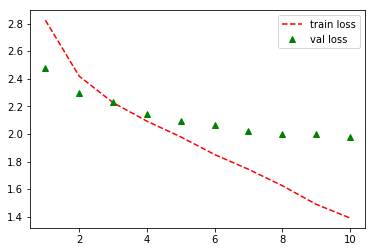

Epoch 11 : [0 / 70]
Epoch 11 : [1 / 70]
Epoch 11 : [2 / 70]
Epoch 11 : [3 / 70]
Epoch 11 : [4 / 70]
Epoch 11 : [5 / 70]
Epoch 11 : [6 / 70]
Epoch 11 : [7 / 70]
Epoch 11 : [8 / 70]
Epoch 11 : [9 / 70]
Epoch 11 : [10 / 70]
Epoch 11 : [11 / 70]
Epoch 11 : [12 / 70]
Epoch 11 : [13 / 70]
Epoch 11 : [14 / 70]
Epoch 11 : [15 / 70]
Epoch 11 : [16 / 70]
Epoch 11 : [17 / 70]
Epoch 11 : [18 / 70]
Epoch 11 : [19 / 70]
Epoch 11 : [20 / 70]
Epoch 11 : [21 / 70]
Epoch 11 : [22 / 70]
Epoch 11 : [23 / 70]
Epoch 11 : [24 / 70]
Epoch 11 : [25 / 70]
Epoch 11 : [26 / 70]
Epoch 11 : [27 / 70]
Epoch 11 : [28 / 70]
Epoch 11 : [29 / 70]
Epoch 11 : [30 / 70]
Epoch 11 : [31 / 70]
Epoch 11 : [32 / 70]
Epoch 11 : [33 / 70]
Epoch 11 : [34 / 70]
Epoch 11 : [35 / 70]
Epoch 11 : [36 / 70]
Epoch 11 : [37 / 70]
Epoch 11 : [38 / 70]
Epoch 11 : [39 / 70]
Epoch 11 : [40 / 70]
Epoch 11 : [41 / 70]
Epoch 11 : [42 / 70]
Epoch 11 : [43 / 70]
Epoch 11 : [44 / 70]
Epoch 11 : [45 / 70]
Epoch 11 : [46 / 70]
Epoch 11 : [47 / 70]
Ep

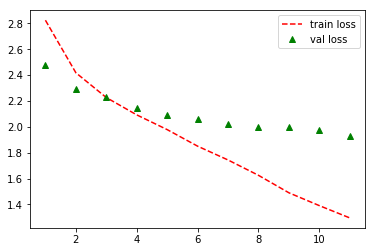

Epoch 12 : [0 / 70]
Epoch 12 : [1 / 70]
Epoch 12 : [2 / 70]
Epoch 12 : [3 / 70]
Epoch 12 : [4 / 70]
Epoch 12 : [5 / 70]
Epoch 12 : [6 / 70]
Epoch 12 : [7 / 70]
Epoch 12 : [8 / 70]
Epoch 12 : [9 / 70]
Epoch 12 : [10 / 70]
Epoch 12 : [11 / 70]
Epoch 12 : [12 / 70]
Epoch 12 : [13 / 70]
Epoch 12 : [14 / 70]
Epoch 12 : [15 / 70]
Epoch 12 : [16 / 70]
Epoch 12 : [17 / 70]
Epoch 12 : [18 / 70]
Epoch 12 : [19 / 70]
Epoch 12 : [20 / 70]
Epoch 12 : [21 / 70]
Epoch 12 : [22 / 70]
Epoch 12 : [23 / 70]
Epoch 12 : [24 / 70]
Epoch 12 : [25 / 70]
Epoch 12 : [26 / 70]
Epoch 12 : [27 / 70]
Epoch 12 : [28 / 70]
Epoch 12 : [29 / 70]
Epoch 12 : [30 / 70]
Epoch 12 : [31 / 70]
Epoch 12 : [32 / 70]
Epoch 12 : [33 / 70]
Epoch 12 : [34 / 70]
Epoch 12 : [35 / 70]
Epoch 12 : [36 / 70]
Epoch 12 : [37 / 70]
Epoch 12 : [38 / 70]
Epoch 12 : [39 / 70]
Epoch 12 : [40 / 70]
Epoch 12 : [41 / 70]
Epoch 12 : [42 / 70]
Epoch 12 : [43 / 70]
Epoch 12 : [44 / 70]
Epoch 12 : [45 / 70]
Epoch 12 : [46 / 70]
Epoch 12 : [47 / 70]
Ep

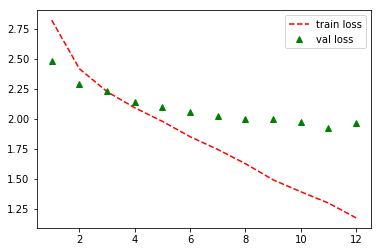

Epoch 13 : [0 / 70]
Epoch 13 : [1 / 70]
Epoch 13 : [2 / 70]
Epoch 13 : [3 / 70]
Epoch 13 : [4 / 70]
Epoch 13 : [5 / 70]
Epoch 13 : [6 / 70]
Epoch 13 : [7 / 70]
Epoch 13 : [8 / 70]
Epoch 13 : [9 / 70]
Epoch 13 : [10 / 70]
Epoch 13 : [11 / 70]
Epoch 13 : [12 / 70]
Epoch 13 : [13 / 70]
Epoch 13 : [14 / 70]
Epoch 13 : [15 / 70]
Epoch 13 : [16 / 70]
Epoch 13 : [17 / 70]
Epoch 13 : [18 / 70]
Epoch 13 : [19 / 70]
Epoch 13 : [20 / 70]
Epoch 13 : [21 / 70]
Epoch 13 : [22 / 70]
Epoch 13 : [23 / 70]
Epoch 13 : [24 / 70]
Epoch 13 : [25 / 70]
Epoch 13 : [26 / 70]
Epoch 13 : [27 / 70]
Epoch 13 : [28 / 70]
Epoch 13 : [29 / 70]
Epoch 13 : [30 / 70]
Epoch 13 : [31 / 70]
Epoch 13 : [32 / 70]
Epoch 13 : [33 / 70]
Epoch 13 : [34 / 70]
Epoch 13 : [35 / 70]
Epoch 13 : [36 / 70]
Epoch 13 : [37 / 70]
Epoch 13 : [38 / 70]
Epoch 13 : [39 / 70]
Epoch 13 : [40 / 70]
Epoch 13 : [41 / 70]
Epoch 13 : [42 / 70]
Epoch 13 : [43 / 70]
Epoch 13 : [44 / 70]
Epoch 13 : [45 / 70]
Epoch 13 : [46 / 70]
Epoch 13 : [47 / 70]
Ep

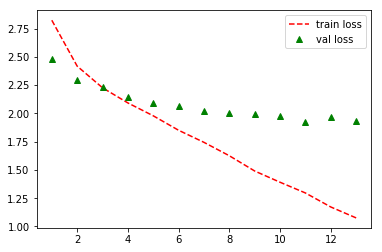

Epoch 14 : [0 / 70]
Epoch 14 : [1 / 70]
Epoch 14 : [2 / 70]
Epoch 14 : [3 / 70]
Epoch 14 : [4 / 70]
Epoch 14 : [5 / 70]
Epoch 14 : [6 / 70]
Epoch 14 : [7 / 70]
Epoch 14 : [8 / 70]
Epoch 14 : [9 / 70]
Epoch 14 : [10 / 70]
Epoch 14 : [11 / 70]
Epoch 14 : [12 / 70]
Epoch 14 : [13 / 70]
Epoch 14 : [14 / 70]
Epoch 14 : [15 / 70]
Epoch 14 : [16 / 70]
Epoch 14 : [17 / 70]
Epoch 14 : [18 / 70]
Epoch 14 : [19 / 70]
Epoch 14 : [20 / 70]
Epoch 14 : [21 / 70]
Epoch 14 : [22 / 70]
Epoch 14 : [23 / 70]
Epoch 14 : [24 / 70]
Epoch 14 : [25 / 70]
Epoch 14 : [26 / 70]
Epoch 14 : [27 / 70]
Epoch 14 : [28 / 70]
Epoch 14 : [29 / 70]
Epoch 14 : [30 / 70]
Epoch 14 : [31 / 70]
Epoch 14 : [32 / 70]
Epoch 14 : [33 / 70]
Epoch 14 : [34 / 70]
Epoch 14 : [35 / 70]
Epoch 14 : [36 / 70]
Epoch 14 : [37 / 70]
Epoch 14 : [38 / 70]
Epoch 14 : [39 / 70]
Epoch 14 : [40 / 70]
Epoch 14 : [41 / 70]
Epoch 14 : [42 / 70]
Epoch 14 : [43 / 70]
Epoch 14 : [44 / 70]
Epoch 14 : [45 / 70]
Epoch 14 : [46 / 70]
Epoch 14 : [47 / 70]
Ep

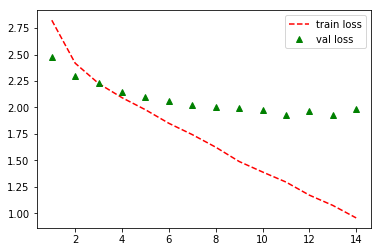

Epoch 15 : [0 / 70]
Epoch 15 : [1 / 70]
Epoch 15 : [2 / 70]
Epoch 15 : [3 / 70]
Epoch 15 : [4 / 70]
Epoch 15 : [5 / 70]
Epoch 15 : [6 / 70]
Epoch 15 : [7 / 70]
Epoch 15 : [8 / 70]
Epoch 15 : [9 / 70]
Epoch 15 : [10 / 70]
Epoch 15 : [11 / 70]
Epoch 15 : [12 / 70]
Epoch 15 : [13 / 70]
Epoch 15 : [14 / 70]
Epoch 15 : [15 / 70]
Epoch 15 : [16 / 70]
Epoch 15 : [17 / 70]
Epoch 15 : [18 / 70]
Epoch 15 : [19 / 70]
Epoch 15 : [20 / 70]
Epoch 15 : [21 / 70]
Epoch 15 : [22 / 70]
Epoch 15 : [23 / 70]
Epoch 15 : [24 / 70]
Epoch 15 : [25 / 70]
Epoch 15 : [26 / 70]
Epoch 15 : [27 / 70]
Epoch 15 : [28 / 70]
Epoch 15 : [29 / 70]
Epoch 15 : [30 / 70]
Epoch 15 : [31 / 70]
Epoch 15 : [32 / 70]
Epoch 15 : [33 / 70]
Epoch 15 : [34 / 70]
Epoch 15 : [35 / 70]
Epoch 15 : [36 / 70]
Epoch 15 : [37 / 70]
Epoch 15 : [38 / 70]
Epoch 15 : [39 / 70]
Epoch 15 : [40 / 70]
Epoch 15 : [41 / 70]
Epoch 15 : [42 / 70]
Epoch 15 : [43 / 70]
Epoch 15 : [44 / 70]
Epoch 15 : [45 / 70]
Epoch 15 : [46 / 70]
Epoch 15 : [47 / 70]
Ep

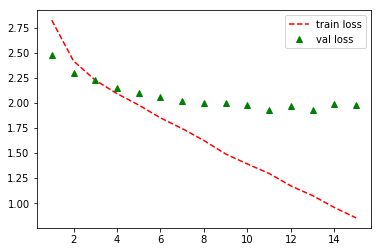

Epoch 16 : [0 / 70]
Epoch 16 : [1 / 70]
Epoch 16 : [2 / 70]
Epoch 16 : [3 / 70]
Epoch 16 : [4 / 70]
Epoch 16 : [5 / 70]
Epoch 16 : [6 / 70]
Epoch 16 : [7 / 70]
Epoch 16 : [8 / 70]
Epoch 16 : [9 / 70]
Epoch 16 : [10 / 70]
Epoch 16 : [11 / 70]
Epoch 16 : [12 / 70]
Epoch 16 : [13 / 70]
Epoch 16 : [14 / 70]
Epoch 16 : [15 / 70]
Epoch 16 : [16 / 70]
Epoch 16 : [17 / 70]
Epoch 16 : [18 / 70]
Epoch 16 : [19 / 70]
Epoch 16 : [20 / 70]
Epoch 16 : [21 / 70]
Epoch 16 : [22 / 70]
Epoch 16 : [23 / 70]
Epoch 16 : [24 / 70]
Epoch 16 : [25 / 70]
Epoch 16 : [26 / 70]
Epoch 16 : [27 / 70]
Epoch 16 : [28 / 70]
Epoch 16 : [29 / 70]
Epoch 16 : [30 / 70]
Epoch 16 : [31 / 70]
Epoch 16 : [32 / 70]
Epoch 16 : [33 / 70]
Epoch 16 : [34 / 70]
Epoch 16 : [35 / 70]
Epoch 16 : [36 / 70]
Epoch 16 : [37 / 70]
Epoch 16 : [38 / 70]
Epoch 16 : [39 / 70]
Epoch 16 : [40 / 70]
Epoch 16 : [41 / 70]
Epoch 16 : [42 / 70]
Epoch 16 : [43 / 70]
Epoch 16 : [44 / 70]
Epoch 16 : [45 / 70]
Epoch 16 : [46 / 70]
Epoch 16 : [47 / 70]
Ep

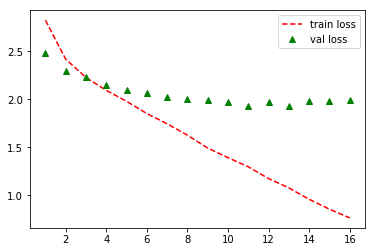

Epoch 17 : [0 / 70]
Epoch 17 : [1 / 70]
Epoch 17 : [2 / 70]
Epoch 17 : [3 / 70]
Epoch 17 : [4 / 70]
Epoch 17 : [5 / 70]
Epoch 17 : [6 / 70]
Epoch 17 : [7 / 70]
Epoch 17 : [8 / 70]
Epoch 17 : [9 / 70]
Epoch 17 : [10 / 70]
Epoch 17 : [11 / 70]
Epoch 17 : [12 / 70]
Epoch 17 : [13 / 70]
Epoch 17 : [14 / 70]
Epoch 17 : [15 / 70]
Epoch 17 : [16 / 70]
Epoch 17 : [17 / 70]
Epoch 17 : [18 / 70]
Epoch 17 : [19 / 70]
Epoch 17 : [20 / 70]
Epoch 17 : [21 / 70]
Epoch 17 : [22 / 70]
Epoch 17 : [23 / 70]
Epoch 17 : [24 / 70]
Epoch 17 : [25 / 70]
Epoch 17 : [26 / 70]
Epoch 17 : [27 / 70]
Epoch 17 : [28 / 70]
Epoch 17 : [29 / 70]
Epoch 17 : [30 / 70]
Epoch 17 : [31 / 70]
Epoch 17 : [32 / 70]
Epoch 17 : [33 / 70]
Epoch 17 : [34 / 70]
Epoch 17 : [35 / 70]
Epoch 17 : [36 / 70]
Epoch 17 : [37 / 70]
Epoch 17 : [38 / 70]
Epoch 17 : [39 / 70]
Epoch 17 : [40 / 70]
Epoch 17 : [41 / 70]
Epoch 17 : [42 / 70]
Epoch 17 : [43 / 70]
Epoch 17 : [44 / 70]
Epoch 17 : [45 / 70]
Epoch 17 : [46 / 70]
Epoch 17 : [47 / 70]
Ep

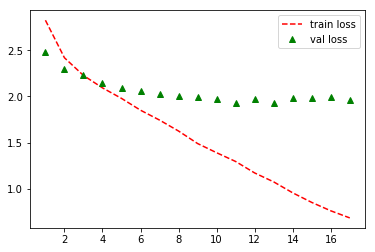

Epoch 18 : [0 / 70]
Epoch 18 : [1 / 70]
Epoch 18 : [2 / 70]
Epoch 18 : [3 / 70]
Epoch 18 : [4 / 70]
Epoch 18 : [5 / 70]
Epoch 18 : [6 / 70]
Epoch 18 : [7 / 70]
Epoch 18 : [8 / 70]
Epoch 18 : [9 / 70]
Epoch 18 : [10 / 70]
Epoch 18 : [11 / 70]
Epoch 18 : [12 / 70]
Epoch 18 : [13 / 70]
Epoch 18 : [14 / 70]
Epoch 18 : [15 / 70]
Epoch 18 : [16 / 70]
Epoch 18 : [17 / 70]
Epoch 18 : [18 / 70]
Epoch 18 : [19 / 70]
Epoch 18 : [20 / 70]
Epoch 18 : [21 / 70]
Epoch 18 : [22 / 70]
Epoch 18 : [23 / 70]
Epoch 18 : [24 / 70]
Epoch 18 : [25 / 70]
Epoch 18 : [26 / 70]
Epoch 18 : [27 / 70]
Epoch 18 : [28 / 70]
Epoch 18 : [29 / 70]
Epoch 18 : [30 / 70]
Epoch 18 : [31 / 70]
Epoch 18 : [32 / 70]
Epoch 18 : [33 / 70]
Epoch 18 : [34 / 70]
Epoch 18 : [35 / 70]
Epoch 18 : [36 / 70]
Epoch 18 : [37 / 70]
Epoch 18 : [38 / 70]
Epoch 18 : [39 / 70]
Epoch 18 : [40 / 70]
Epoch 18 : [41 / 70]
Epoch 18 : [42 / 70]
Epoch 18 : [43 / 70]
Epoch 18 : [44 / 70]
Epoch 18 : [45 / 70]
Epoch 18 : [46 / 70]
Epoch 18 : [47 / 70]
Ep

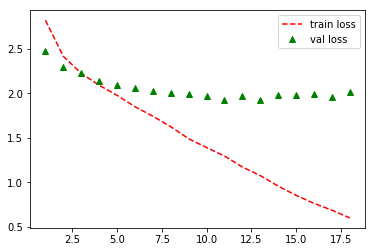

Epoch 19 : [0 / 70]
Epoch 19 : [1 / 70]
Epoch 19 : [2 / 70]
Epoch 19 : [3 / 70]
Epoch 19 : [4 / 70]
Epoch 19 : [5 / 70]
Epoch 19 : [6 / 70]
Epoch 19 : [7 / 70]
Epoch 19 : [8 / 70]
Epoch 19 : [9 / 70]
Epoch 19 : [10 / 70]
Epoch 19 : [11 / 70]
Epoch 19 : [12 / 70]
Epoch 19 : [13 / 70]
Epoch 19 : [14 / 70]
Epoch 19 : [15 / 70]
Epoch 19 : [16 / 70]
Epoch 19 : [17 / 70]
Epoch 19 : [18 / 70]
Epoch 19 : [19 / 70]
Epoch 19 : [20 / 70]
Epoch 19 : [21 / 70]
Epoch 19 : [22 / 70]
Epoch 19 : [23 / 70]
Epoch 19 : [24 / 70]
Epoch 19 : [25 / 70]
Epoch 19 : [26 / 70]
Epoch 19 : [27 / 70]
Epoch 19 : [28 / 70]
Epoch 19 : [29 / 70]
Epoch 19 : [30 / 70]
Epoch 19 : [31 / 70]
Epoch 19 : [32 / 70]
Epoch 19 : [33 / 70]
Epoch 19 : [34 / 70]
Epoch 19 : [35 / 70]
Epoch 19 : [36 / 70]
Epoch 19 : [37 / 70]
Epoch 19 : [38 / 70]
Epoch 19 : [39 / 70]
Epoch 19 : [40 / 70]
Epoch 19 : [41 / 70]
Epoch 19 : [42 / 70]
Epoch 19 : [43 / 70]
Epoch 19 : [44 / 70]
Epoch 19 : [45 / 70]
Epoch 19 : [46 / 70]
Epoch 19 : [47 / 70]
Ep

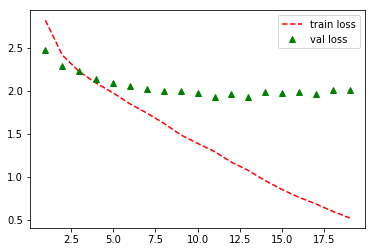

Epoch 20 : [0 / 70]
Epoch 20 : [1 / 70]
Epoch 20 : [2 / 70]
Epoch 20 : [3 / 70]
Epoch 20 : [4 / 70]
Epoch 20 : [5 / 70]
Epoch 20 : [6 / 70]
Epoch 20 : [7 / 70]
Epoch 20 : [8 / 70]
Epoch 20 : [9 / 70]
Epoch 20 : [10 / 70]
Epoch 20 : [11 / 70]
Epoch 20 : [12 / 70]
Epoch 20 : [13 / 70]
Epoch 20 : [14 / 70]
Epoch 20 : [15 / 70]
Epoch 20 : [16 / 70]
Epoch 20 : [17 / 70]
Epoch 20 : [18 / 70]
Epoch 20 : [19 / 70]
Epoch 20 : [20 / 70]
Epoch 20 : [21 / 70]
Epoch 20 : [22 / 70]
Epoch 20 : [23 / 70]
Epoch 20 : [24 / 70]
Epoch 20 : [25 / 70]
Epoch 20 : [26 / 70]
Epoch 20 : [27 / 70]
Epoch 20 : [28 / 70]
Epoch 20 : [29 / 70]
Epoch 20 : [30 / 70]
Epoch 20 : [31 / 70]
Epoch 20 : [32 / 70]
Epoch 20 : [33 / 70]
Epoch 20 : [34 / 70]
Epoch 20 : [35 / 70]
Epoch 20 : [36 / 70]
Epoch 20 : [37 / 70]
Epoch 20 : [38 / 70]
Epoch 20 : [39 / 70]
Epoch 20 : [40 / 70]
Epoch 20 : [41 / 70]
Epoch 20 : [42 / 70]
Epoch 20 : [43 / 70]
Epoch 20 : [44 / 70]
Epoch 20 : [45 / 70]
Epoch 20 : [46 / 70]
Epoch 20 : [47 / 70]
Ep

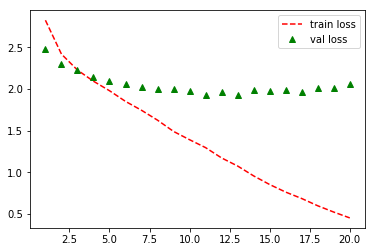

Epoch 21 : [0 / 70]
Epoch 21 : [1 / 70]
Epoch 21 : [2 / 70]
Epoch 21 : [3 / 70]
Epoch 21 : [4 / 70]
Epoch 21 : [5 / 70]
Epoch 21 : [6 / 70]
Epoch 21 : [7 / 70]
Epoch 21 : [8 / 70]
Epoch 21 : [9 / 70]
Epoch 21 : [10 / 70]
Epoch 21 : [11 / 70]
Epoch 21 : [12 / 70]
Epoch 21 : [13 / 70]
Epoch 21 : [14 / 70]
Epoch 21 : [15 / 70]
Epoch 21 : [16 / 70]
Epoch 21 : [17 / 70]
Epoch 21 : [18 / 70]
Epoch 21 : [19 / 70]
Epoch 21 : [20 / 70]
Epoch 21 : [21 / 70]
Epoch 21 : [22 / 70]
Epoch 21 : [23 / 70]
Epoch 21 : [24 / 70]
Epoch 21 : [25 / 70]
Epoch 21 : [26 / 70]
Epoch 21 : [27 / 70]
Epoch 21 : [28 / 70]
Epoch 21 : [29 / 70]
Epoch 21 : [30 / 70]
Epoch 21 : [31 / 70]
Epoch 21 : [32 / 70]
Epoch 21 : [33 / 70]
Epoch 21 : [34 / 70]
Epoch 21 : [35 / 70]
Epoch 21 : [36 / 70]
Epoch 21 : [37 / 70]
Epoch 21 : [38 / 70]
Epoch 21 : [39 / 70]
Epoch 21 : [40 / 70]
Epoch 21 : [41 / 70]
Epoch 21 : [42 / 70]
Epoch 21 : [43 / 70]
Epoch 21 : [44 / 70]
Epoch 21 : [45 / 70]
Epoch 21 : [46 / 70]
Epoch 21 : [47 / 70]
Ep

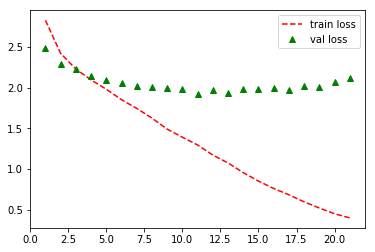

Epoch 22 : [0 / 70]
Epoch 22 : [1 / 70]
Epoch 22 : [2 / 70]
Epoch 22 : [3 / 70]
Epoch 22 : [4 / 70]
Epoch 22 : [5 / 70]
Epoch 22 : [6 / 70]
Epoch 22 : [7 / 70]
Epoch 22 : [8 / 70]
Epoch 22 : [9 / 70]
Epoch 22 : [10 / 70]
Epoch 22 : [11 / 70]
Epoch 22 : [12 / 70]
Epoch 22 : [13 / 70]
Epoch 22 : [14 / 70]
Epoch 22 : [15 / 70]
Epoch 22 : [16 / 70]
Epoch 22 : [17 / 70]
Epoch 22 : [18 / 70]
Epoch 22 : [19 / 70]
Epoch 22 : [20 / 70]
Epoch 22 : [21 / 70]
Epoch 22 : [22 / 70]
Epoch 22 : [23 / 70]
Epoch 22 : [24 / 70]
Epoch 22 : [25 / 70]
Epoch 22 : [26 / 70]
Epoch 22 : [27 / 70]
Epoch 22 : [28 / 70]
Epoch 22 : [29 / 70]
Epoch 22 : [30 / 70]
Epoch 22 : [31 / 70]
Epoch 22 : [32 / 70]
Epoch 22 : [33 / 70]
Epoch 22 : [34 / 70]
Epoch 22 : [35 / 70]
Epoch 22 : [36 / 70]
Epoch 22 : [37 / 70]
Epoch 22 : [38 / 70]
Epoch 22 : [39 / 70]
Epoch 22 : [40 / 70]
Epoch 22 : [41 / 70]
Epoch 22 : [42 / 70]
Epoch 22 : [43 / 70]
Epoch 22 : [44 / 70]
Epoch 22 : [45 / 70]
Epoch 22 : [46 / 70]
Epoch 22 : [47 / 70]
Ep

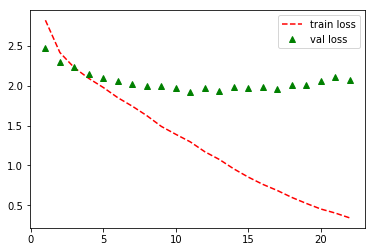

Epoch 23 : [0 / 70]
Epoch 23 : [1 / 70]
Epoch 23 : [2 / 70]
Epoch 23 : [3 / 70]
Epoch 23 : [4 / 70]
Epoch 23 : [5 / 70]
Epoch 23 : [6 / 70]
Epoch 23 : [7 / 70]
Epoch 23 : [8 / 70]
Epoch 23 : [9 / 70]
Epoch 23 : [10 / 70]
Epoch 23 : [11 / 70]
Epoch 23 : [12 / 70]
Epoch 23 : [13 / 70]
Epoch 23 : [14 / 70]
Epoch 23 : [15 / 70]
Epoch 23 : [16 / 70]
Epoch 23 : [17 / 70]
Epoch 23 : [18 / 70]
Epoch 23 : [19 / 70]
Epoch 23 : [20 / 70]
Epoch 23 : [21 / 70]
Epoch 23 : [22 / 70]
Epoch 23 : [23 / 70]
Epoch 23 : [24 / 70]
Epoch 23 : [25 / 70]
Epoch 23 : [26 / 70]
Epoch 23 : [27 / 70]
Epoch 23 : [28 / 70]
Epoch 23 : [29 / 70]
Epoch 23 : [30 / 70]
Epoch 23 : [31 / 70]
Epoch 23 : [32 / 70]
Epoch 23 : [33 / 70]
Epoch 23 : [34 / 70]
Epoch 23 : [35 / 70]
Epoch 23 : [36 / 70]
Epoch 23 : [37 / 70]
Epoch 23 : [38 / 70]
Epoch 23 : [39 / 70]
Epoch 23 : [40 / 70]
Epoch 23 : [41 / 70]
Epoch 23 : [42 / 70]
Epoch 23 : [43 / 70]
Epoch 23 : [44 / 70]
Epoch 23 : [45 / 70]
Epoch 23 : [46 / 70]
Epoch 23 : [47 / 70]
Ep

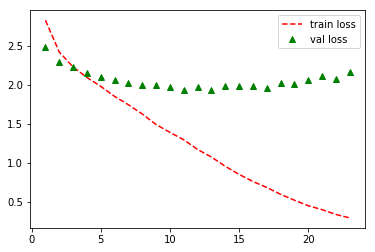

Epoch 24 : [0 / 70]
Epoch 24 : [1 / 70]
Epoch 24 : [2 / 70]
Epoch 24 : [3 / 70]
Epoch 24 : [4 / 70]
Epoch 24 : [5 / 70]
Epoch 24 : [6 / 70]
Epoch 24 : [7 / 70]
Epoch 24 : [8 / 70]
Epoch 24 : [9 / 70]
Epoch 24 : [10 / 70]
Epoch 24 : [11 / 70]
Epoch 24 : [12 / 70]
Epoch 24 : [13 / 70]
Epoch 24 : [14 / 70]
Epoch 24 : [15 / 70]
Epoch 24 : [16 / 70]
Epoch 24 : [17 / 70]
Epoch 24 : [18 / 70]
Epoch 24 : [19 / 70]
Epoch 24 : [20 / 70]
Epoch 24 : [21 / 70]
Epoch 24 : [22 / 70]
Epoch 24 : [23 / 70]
Epoch 24 : [24 / 70]
Epoch 24 : [25 / 70]
Epoch 24 : [26 / 70]
Epoch 24 : [27 / 70]
Epoch 24 : [28 / 70]
Epoch 24 : [29 / 70]
Epoch 24 : [30 / 70]
Epoch 24 : [31 / 70]
Epoch 24 : [32 / 70]
Epoch 24 : [33 / 70]
Epoch 24 : [34 / 70]
Epoch 24 : [35 / 70]
Epoch 24 : [36 / 70]
Epoch 24 : [37 / 70]
Epoch 24 : [38 / 70]
Epoch 24 : [39 / 70]
Epoch 24 : [40 / 70]
Epoch 24 : [41 / 70]
Epoch 24 : [42 / 70]
Epoch 24 : [43 / 70]
Epoch 24 : [44 / 70]
Epoch 24 : [45 / 70]
Epoch 24 : [46 / 70]
Epoch 24 : [47 / 70]
Ep

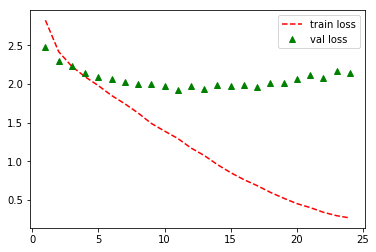

Epoch 25 : [0 / 70]
Epoch 25 : [1 / 70]
Epoch 25 : [2 / 70]
Epoch 25 : [3 / 70]
Epoch 25 : [4 / 70]
Epoch 25 : [5 / 70]
Epoch 25 : [6 / 70]
Epoch 25 : [7 / 70]
Epoch 25 : [8 / 70]
Epoch 25 : [9 / 70]
Epoch 25 : [10 / 70]
Epoch 25 : [11 / 70]
Epoch 25 : [12 / 70]
Epoch 25 : [13 / 70]
Epoch 25 : [14 / 70]
Epoch 25 : [15 / 70]
Epoch 25 : [16 / 70]
Epoch 25 : [17 / 70]
Epoch 25 : [18 / 70]
Epoch 25 : [19 / 70]
Epoch 25 : [20 / 70]
Epoch 25 : [21 / 70]
Epoch 25 : [22 / 70]
Epoch 25 : [23 / 70]
Epoch 25 : [24 / 70]
Epoch 25 : [25 / 70]
Epoch 25 : [26 / 70]
Epoch 25 : [27 / 70]
Epoch 25 : [28 / 70]
Epoch 25 : [29 / 70]
Epoch 25 : [30 / 70]
Epoch 25 : [31 / 70]
Epoch 25 : [32 / 70]
Epoch 25 : [33 / 70]
Epoch 25 : [34 / 70]
Epoch 25 : [35 / 70]
Epoch 25 : [36 / 70]
Epoch 25 : [37 / 70]
Epoch 25 : [38 / 70]
Epoch 25 : [39 / 70]
Epoch 25 : [40 / 70]
Epoch 25 : [41 / 70]
Epoch 25 : [42 / 70]
Epoch 25 : [43 / 70]
Epoch 25 : [44 / 70]
Epoch 25 : [45 / 70]
Epoch 25 : [46 / 70]
Epoch 25 : [47 / 70]
Ep

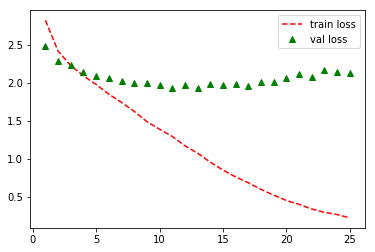

Epoch 26 : [0 / 70]
Epoch 26 : [1 / 70]
Epoch 26 : [2 / 70]
Epoch 26 : [3 / 70]
Epoch 26 : [4 / 70]
Epoch 26 : [5 / 70]
Epoch 26 : [6 / 70]
Epoch 26 : [7 / 70]
Epoch 26 : [8 / 70]
Epoch 26 : [9 / 70]
Epoch 26 : [10 / 70]
Epoch 26 : [11 / 70]
Epoch 26 : [12 / 70]
Epoch 26 : [13 / 70]
Epoch 26 : [14 / 70]
Epoch 26 : [15 / 70]
Epoch 26 : [16 / 70]
Epoch 26 : [17 / 70]
Epoch 26 : [18 / 70]
Epoch 26 : [19 / 70]
Epoch 26 : [20 / 70]
Epoch 26 : [21 / 70]
Epoch 26 : [22 / 70]
Epoch 26 : [23 / 70]
Epoch 26 : [24 / 70]
Epoch 26 : [25 / 70]
Epoch 26 : [26 / 70]
Epoch 26 : [27 / 70]
Epoch 26 : [28 / 70]
Epoch 26 : [29 / 70]
Epoch 26 : [30 / 70]
Epoch 26 : [31 / 70]
Epoch 26 : [32 / 70]
Epoch 26 : [33 / 70]
Epoch 26 : [34 / 70]
Epoch 26 : [35 / 70]
Epoch 26 : [36 / 70]
Epoch 26 : [37 / 70]
Epoch 26 : [38 / 70]
Epoch 26 : [39 / 70]
Epoch 26 : [40 / 70]
Epoch 26 : [41 / 70]
Epoch 26 : [42 / 70]
Epoch 26 : [43 / 70]
Epoch 26 : [44 / 70]
Epoch 26 : [45 / 70]
Epoch 26 : [46 / 70]
Epoch 26 : [47 / 70]
Ep

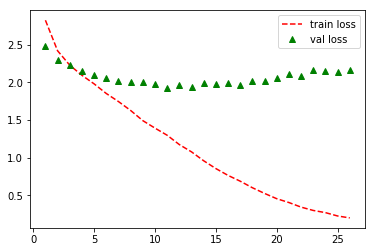

Epoch 27 : [0 / 70]
Epoch 27 : [1 / 70]
Epoch 27 : [2 / 70]
Epoch 27 : [3 / 70]
Epoch 27 : [4 / 70]
Epoch 27 : [5 / 70]
Epoch 27 : [6 / 70]
Epoch 27 : [7 / 70]
Epoch 27 : [8 / 70]
Epoch 27 : [9 / 70]
Epoch 27 : [10 / 70]
Epoch 27 : [11 / 70]
Epoch 27 : [12 / 70]
Epoch 27 : [13 / 70]
Epoch 27 : [14 / 70]
Epoch 27 : [15 / 70]
Epoch 27 : [16 / 70]
Epoch 27 : [17 / 70]
Epoch 27 : [18 / 70]
Epoch 27 : [19 / 70]
Epoch 27 : [20 / 70]
Epoch 27 : [21 / 70]
Epoch 27 : [22 / 70]
Epoch 27 : [23 / 70]
Epoch 27 : [24 / 70]
Epoch 27 : [25 / 70]
Epoch 27 : [26 / 70]
Epoch 27 : [27 / 70]
Epoch 27 : [28 / 70]
Epoch 27 : [29 / 70]
Epoch 27 : [30 / 70]
Epoch 27 : [31 / 70]
Epoch 27 : [32 / 70]
Epoch 27 : [33 / 70]
Epoch 27 : [34 / 70]
Epoch 27 : [35 / 70]
Epoch 27 : [36 / 70]
Epoch 27 : [37 / 70]
Epoch 27 : [38 / 70]
Epoch 27 : [39 / 70]
Epoch 27 : [40 / 70]
Epoch 27 : [41 / 70]
Epoch 27 : [42 / 70]
Epoch 27 : [43 / 70]
Epoch 27 : [44 / 70]
Epoch 27 : [45 / 70]
Epoch 27 : [46 / 70]
Epoch 27 : [47 / 70]
Ep

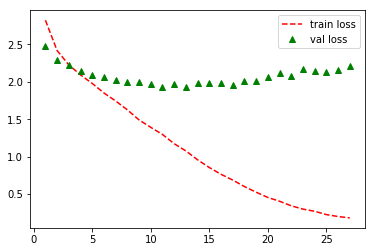

Epoch 28 : [0 / 70]
Epoch 28 : [1 / 70]
Epoch 28 : [2 / 70]
Epoch 28 : [3 / 70]
Epoch 28 : [4 / 70]
Epoch 28 : [5 / 70]
Epoch 28 : [6 / 70]
Epoch 28 : [7 / 70]
Epoch 28 : [8 / 70]
Epoch 28 : [9 / 70]
Epoch 28 : [10 / 70]
Epoch 28 : [11 / 70]
Epoch 28 : [12 / 70]
Epoch 28 : [13 / 70]
Epoch 28 : [14 / 70]
Epoch 28 : [15 / 70]
Epoch 28 : [16 / 70]
Epoch 28 : [17 / 70]
Epoch 28 : [18 / 70]
Epoch 28 : [19 / 70]
Epoch 28 : [20 / 70]
Epoch 28 : [21 / 70]
Epoch 28 : [22 / 70]
Epoch 28 : [23 / 70]
Epoch 28 : [24 / 70]
Epoch 28 : [25 / 70]
Epoch 28 : [26 / 70]
Epoch 28 : [27 / 70]
Epoch 28 : [28 / 70]
Epoch 28 : [29 / 70]
Epoch 28 : [30 / 70]
Epoch 28 : [31 / 70]
Epoch 28 : [32 / 70]
Epoch 28 : [33 / 70]
Epoch 28 : [34 / 70]
Epoch 28 : [35 / 70]
Epoch 28 : [36 / 70]
Epoch 28 : [37 / 70]
Epoch 28 : [38 / 70]
Epoch 28 : [39 / 70]
Epoch 28 : [40 / 70]
Epoch 28 : [41 / 70]
Epoch 28 : [42 / 70]
Epoch 28 : [43 / 70]
Epoch 28 : [44 / 70]
Epoch 28 : [45 / 70]
Epoch 28 : [46 / 70]
Epoch 28 : [47 / 70]
Ep

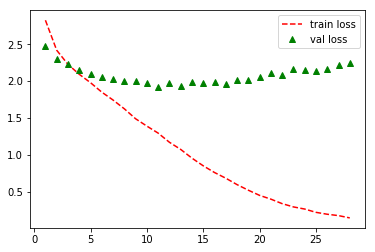

Epoch 29 : [0 / 70]
Epoch 29 : [1 / 70]
Epoch 29 : [2 / 70]
Epoch 29 : [3 / 70]
Epoch 29 : [4 / 70]
Epoch 29 : [5 / 70]
Epoch 29 : [6 / 70]
Epoch 29 : [7 / 70]
Epoch 29 : [8 / 70]
Epoch 29 : [9 / 70]
Epoch 29 : [10 / 70]
Epoch 29 : [11 / 70]
Epoch 29 : [12 / 70]
Epoch 29 : [13 / 70]
Epoch 29 : [14 / 70]
Epoch 29 : [15 / 70]
Epoch 29 : [16 / 70]
Epoch 29 : [17 / 70]
Epoch 29 : [18 / 70]
Epoch 29 : [19 / 70]
Epoch 29 : [20 / 70]
Epoch 29 : [21 / 70]
Epoch 29 : [22 / 70]
Epoch 29 : [23 / 70]
Epoch 29 : [24 / 70]
Epoch 29 : [25 / 70]
Epoch 29 : [26 / 70]
Epoch 29 : [27 / 70]
Epoch 29 : [28 / 70]
Epoch 29 : [29 / 70]
Epoch 29 : [30 / 70]
Epoch 29 : [31 / 70]
Epoch 29 : [32 / 70]
Epoch 29 : [33 / 70]
Epoch 29 : [34 / 70]
Epoch 29 : [35 / 70]
Epoch 29 : [36 / 70]
Epoch 29 : [37 / 70]
Epoch 29 : [38 / 70]
Epoch 29 : [39 / 70]
Epoch 29 : [40 / 70]
Epoch 29 : [41 / 70]
Epoch 29 : [42 / 70]
Epoch 29 : [43 / 70]
Epoch 29 : [44 / 70]
Epoch 29 : [45 / 70]
Epoch 29 : [46 / 70]
Epoch 29 : [47 / 70]
Ep

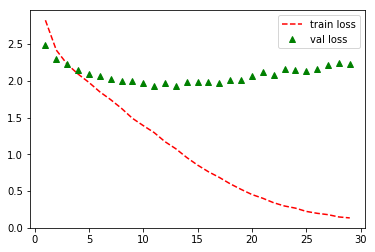

Epoch 30 : [0 / 70]
Epoch 30 : [1 / 70]
Epoch 30 : [2 / 70]
Epoch 30 : [3 / 70]
Epoch 30 : [4 / 70]
Epoch 30 : [5 / 70]
Epoch 30 : [6 / 70]
Epoch 30 : [7 / 70]
Epoch 30 : [8 / 70]
Epoch 30 : [9 / 70]
Epoch 30 : [10 / 70]
Epoch 30 : [11 / 70]
Epoch 30 : [12 / 70]
Epoch 30 : [13 / 70]
Epoch 30 : [14 / 70]
Epoch 30 : [15 / 70]
Epoch 30 : [16 / 70]
Epoch 30 : [17 / 70]
Epoch 30 : [18 / 70]
Epoch 30 : [19 / 70]
Epoch 30 : [20 / 70]
Epoch 30 : [21 / 70]
Epoch 30 : [22 / 70]
Epoch 30 : [23 / 70]
Epoch 30 : [24 / 70]
Epoch 30 : [25 / 70]
Epoch 30 : [26 / 70]
Epoch 30 : [27 / 70]
Epoch 30 : [28 / 70]
Epoch 30 : [29 / 70]
Epoch 30 : [30 / 70]
Epoch 30 : [31 / 70]
Epoch 30 : [32 / 70]
Epoch 30 : [33 / 70]
Epoch 30 : [34 / 70]
Epoch 30 : [35 / 70]
Epoch 30 : [36 / 70]
Epoch 30 : [37 / 70]
Epoch 30 : [38 / 70]
Epoch 30 : [39 / 70]
Epoch 30 : [40 / 70]
Epoch 30 : [41 / 70]
Epoch 30 : [42 / 70]
Epoch 30 : [43 / 70]
Epoch 30 : [44 / 70]
Epoch 30 : [45 / 70]
Epoch 30 : [46 / 70]
Epoch 30 : [47 / 70]
Ep

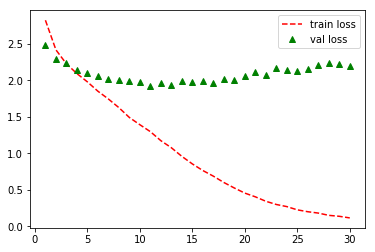

Epoch 31 : [0 / 70]
Epoch 31 : [1 / 70]
Epoch 31 : [2 / 70]
Epoch 31 : [3 / 70]
Epoch 31 : [4 / 70]
Epoch 31 : [5 / 70]
Epoch 31 : [6 / 70]
Epoch 31 : [7 / 70]
Epoch 31 : [8 / 70]
Epoch 31 : [9 / 70]
Epoch 31 : [10 / 70]
Epoch 31 : [11 / 70]
Epoch 31 : [12 / 70]
Epoch 31 : [13 / 70]
Epoch 31 : [14 / 70]
Epoch 31 : [15 / 70]
Epoch 31 : [16 / 70]
Epoch 31 : [17 / 70]
Epoch 31 : [18 / 70]
Epoch 31 : [19 / 70]
Epoch 31 : [20 / 70]
Epoch 31 : [21 / 70]
Epoch 31 : [22 / 70]
Epoch 31 : [23 / 70]
Epoch 31 : [24 / 70]
Epoch 31 : [25 / 70]
Epoch 31 : [26 / 70]
Epoch 31 : [27 / 70]
Epoch 31 : [28 / 70]
Epoch 31 : [29 / 70]
Epoch 31 : [30 / 70]
Epoch 31 : [31 / 70]
Epoch 31 : [32 / 70]
Epoch 31 : [33 / 70]
Epoch 31 : [34 / 70]
Epoch 31 : [35 / 70]
Epoch 31 : [36 / 70]
Epoch 31 : [37 / 70]
Epoch 31 : [38 / 70]
Epoch 31 : [39 / 70]
Epoch 31 : [40 / 70]
Epoch 31 : [41 / 70]
Epoch 31 : [42 / 70]
Epoch 31 : [43 / 70]
Epoch 31 : [44 / 70]
Epoch 31 : [45 / 70]
Epoch 31 : [46 / 70]
Epoch 31 : [47 / 70]
Ep

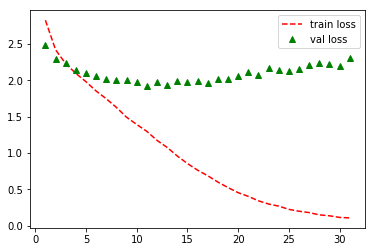

Epoch 32 : [0 / 70]
Epoch 32 : [1 / 70]
Epoch 32 : [2 / 70]
Epoch 32 : [3 / 70]
Epoch 32 : [4 / 70]
Epoch 32 : [5 / 70]
Epoch 32 : [6 / 70]
Epoch 32 : [7 / 70]
Epoch 32 : [8 / 70]
Epoch 32 : [9 / 70]
Epoch 32 : [10 / 70]
Epoch 32 : [11 / 70]
Epoch 32 : [12 / 70]
Epoch 32 : [13 / 70]
Epoch 32 : [14 / 70]
Epoch 32 : [15 / 70]
Epoch 32 : [16 / 70]
Epoch 32 : [17 / 70]
Epoch 32 : [18 / 70]
Epoch 32 : [19 / 70]
Epoch 32 : [20 / 70]
Epoch 32 : [21 / 70]
Epoch 32 : [22 / 70]
Epoch 32 : [23 / 70]
Epoch 32 : [24 / 70]
Epoch 32 : [25 / 70]
Epoch 32 : [26 / 70]
Epoch 32 : [27 / 70]
Epoch 32 : [28 / 70]
Epoch 32 : [29 / 70]
Epoch 32 : [30 / 70]
Epoch 32 : [31 / 70]
Epoch 32 : [32 / 70]
Epoch 32 : [33 / 70]
Epoch 32 : [34 / 70]
Epoch 32 : [35 / 70]
Epoch 32 : [36 / 70]
Epoch 32 : [37 / 70]
Epoch 32 : [38 / 70]
Epoch 32 : [39 / 70]
Epoch 32 : [40 / 70]
Epoch 32 : [41 / 70]
Epoch 32 : [42 / 70]
Epoch 32 : [43 / 70]
Epoch 32 : [44 / 70]
Epoch 32 : [45 / 70]
Epoch 32 : [46 / 70]
Epoch 32 : [47 / 70]
Ep

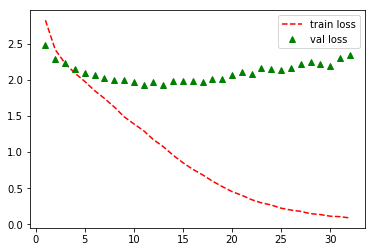

Epoch 33 : [0 / 70]
Epoch 33 : [1 / 70]
Epoch 33 : [2 / 70]
Epoch 33 : [3 / 70]
Epoch 33 : [4 / 70]
Epoch 33 : [5 / 70]
Epoch 33 : [6 / 70]
Epoch 33 : [7 / 70]
Epoch 33 : [8 / 70]
Epoch 33 : [9 / 70]
Epoch 33 : [10 / 70]
Epoch 33 : [11 / 70]
Epoch 33 : [12 / 70]
Epoch 33 : [13 / 70]
Epoch 33 : [14 / 70]
Epoch 33 : [15 / 70]
Epoch 33 : [16 / 70]
Epoch 33 : [17 / 70]
Epoch 33 : [18 / 70]
Epoch 33 : [19 / 70]
Epoch 33 : [20 / 70]
Epoch 33 : [21 / 70]
Epoch 33 : [22 / 70]
Epoch 33 : [23 / 70]
Epoch 33 : [24 / 70]
Epoch 33 : [25 / 70]
Epoch 33 : [26 / 70]
Epoch 33 : [27 / 70]
Epoch 33 : [28 / 70]
Epoch 33 : [29 / 70]
Epoch 33 : [30 / 70]
Epoch 33 : [31 / 70]
Epoch 33 : [32 / 70]
Epoch 33 : [33 / 70]
Epoch 33 : [34 / 70]
Epoch 33 : [35 / 70]
Epoch 33 : [36 / 70]
Epoch 33 : [37 / 70]
Epoch 33 : [38 / 70]
Epoch 33 : [39 / 70]
Epoch 33 : [40 / 70]
Epoch 33 : [41 / 70]
Epoch 33 : [42 / 70]
Epoch 33 : [43 / 70]
Epoch 33 : [44 / 70]
Epoch 33 : [45 / 70]
Epoch 33 : [46 / 70]
Epoch 33 : [47 / 70]
Ep

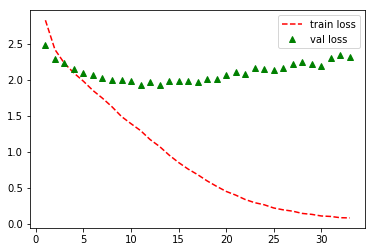

Epoch 34 : [0 / 70]
Epoch 34 : [1 / 70]
Epoch 34 : [2 / 70]
Epoch 34 : [3 / 70]
Epoch 34 : [4 / 70]
Epoch 34 : [5 / 70]
Epoch 34 : [6 / 70]
Epoch 34 : [7 / 70]
Epoch 34 : [8 / 70]
Epoch 34 : [9 / 70]
Epoch 34 : [10 / 70]
Epoch 34 : [11 / 70]
Epoch 34 : [12 / 70]
Epoch 34 : [13 / 70]
Epoch 34 : [14 / 70]
Epoch 34 : [15 / 70]
Epoch 34 : [16 / 70]
Epoch 34 : [17 / 70]
Epoch 34 : [18 / 70]
Epoch 34 : [19 / 70]
Epoch 34 : [20 / 70]
Epoch 34 : [21 / 70]
Epoch 34 : [22 / 70]
Epoch 34 : [23 / 70]
Epoch 34 : [24 / 70]
Epoch 34 : [25 / 70]
Epoch 34 : [26 / 70]
Epoch 34 : [27 / 70]
Epoch 34 : [28 / 70]
Epoch 34 : [29 / 70]
Epoch 34 : [30 / 70]
Epoch 34 : [31 / 70]
Epoch 34 : [32 / 70]
Epoch 34 : [33 / 70]
Epoch 34 : [34 / 70]
Epoch 34 : [35 / 70]
Epoch 34 : [36 / 70]
Epoch 34 : [37 / 70]
Epoch 34 : [38 / 70]
Epoch 34 : [39 / 70]
Epoch 34 : [40 / 70]
Epoch 34 : [41 / 70]
Epoch 34 : [42 / 70]
Epoch 34 : [43 / 70]
Epoch 34 : [44 / 70]
Epoch 34 : [45 / 70]
Epoch 34 : [46 / 70]
Epoch 34 : [47 / 70]
Ep

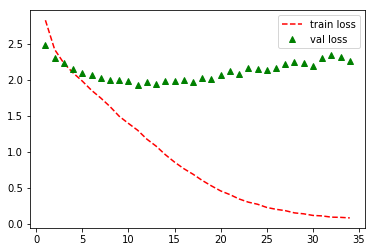

Epoch 35 : [0 / 70]
Epoch 35 : [1 / 70]
Epoch 35 : [2 / 70]
Epoch 35 : [3 / 70]
Epoch 35 : [4 / 70]
Epoch 35 : [5 / 70]
Epoch 35 : [6 / 70]
Epoch 35 : [7 / 70]
Epoch 35 : [8 / 70]
Epoch 35 : [9 / 70]
Epoch 35 : [10 / 70]
Epoch 35 : [11 / 70]
Epoch 35 : [12 / 70]
Epoch 35 : [13 / 70]
Epoch 35 : [14 / 70]
Epoch 35 : [15 / 70]
Epoch 35 : [16 / 70]
Epoch 35 : [17 / 70]
Epoch 35 : [18 / 70]
Epoch 35 : [19 / 70]
Epoch 35 : [20 / 70]
Epoch 35 : [21 / 70]
Epoch 35 : [22 / 70]
Epoch 35 : [23 / 70]
Epoch 35 : [24 / 70]
Epoch 35 : [25 / 70]
Epoch 35 : [26 / 70]
Epoch 35 : [27 / 70]
Epoch 35 : [28 / 70]
Epoch 35 : [29 / 70]
Epoch 35 : [30 / 70]
Epoch 35 : [31 / 70]
Epoch 35 : [32 / 70]
Epoch 35 : [33 / 70]
Epoch 35 : [34 / 70]
Epoch 35 : [35 / 70]
Epoch 35 : [36 / 70]
Epoch 35 : [37 / 70]
Epoch 35 : [38 / 70]
Epoch 35 : [39 / 70]
Epoch 35 : [40 / 70]
Epoch 35 : [41 / 70]
Epoch 35 : [42 / 70]
Epoch 35 : [43 / 70]
Epoch 35 : [44 / 70]
Epoch 35 : [45 / 70]
Epoch 35 : [46 / 70]
Epoch 35 : [47 / 70]
Ep

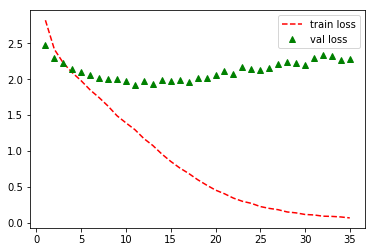

Epoch 36 : [0 / 70]
Epoch 36 : [1 / 70]
Epoch 36 : [2 / 70]
Epoch 36 : [3 / 70]
Epoch 36 : [4 / 70]
Epoch 36 : [5 / 70]
Epoch 36 : [6 / 70]
Epoch 36 : [7 / 70]
Epoch 36 : [8 / 70]
Epoch 36 : [9 / 70]
Epoch 36 : [10 / 70]
Epoch 36 : [11 / 70]
Epoch 36 : [12 / 70]
Epoch 36 : [13 / 70]
Epoch 36 : [14 / 70]
Epoch 36 : [15 / 70]
Epoch 36 : [16 / 70]
Epoch 36 : [17 / 70]
Epoch 36 : [18 / 70]
Epoch 36 : [19 / 70]
Epoch 36 : [20 / 70]
Epoch 36 : [21 / 70]
Epoch 36 : [22 / 70]
Epoch 36 : [23 / 70]
Epoch 36 : [24 / 70]
Epoch 36 : [25 / 70]
Epoch 36 : [26 / 70]
Epoch 36 : [27 / 70]
Epoch 36 : [28 / 70]
Epoch 36 : [29 / 70]
Epoch 36 : [30 / 70]
Epoch 36 : [31 / 70]
Epoch 36 : [32 / 70]
Epoch 36 : [33 / 70]
Epoch 36 : [34 / 70]
Epoch 36 : [35 / 70]
Epoch 36 : [36 / 70]
Epoch 36 : [37 / 70]
Epoch 36 : [38 / 70]
Epoch 36 : [39 / 70]
Epoch 36 : [40 / 70]
Epoch 36 : [41 / 70]
Epoch 36 : [42 / 70]
Epoch 36 : [43 / 70]
Epoch 36 : [44 / 70]
Epoch 36 : [45 / 70]
Epoch 36 : [46 / 70]
Epoch 36 : [47 / 70]
Ep

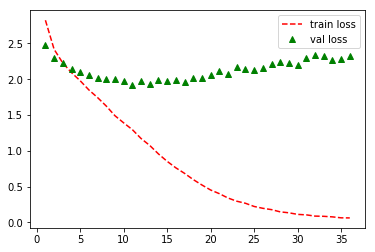

Epoch 37 : [0 / 70]
Epoch 37 : [1 / 70]
Epoch 37 : [2 / 70]
Epoch 37 : [3 / 70]
Epoch 37 : [4 / 70]
Epoch 37 : [5 / 70]
Epoch 37 : [6 / 70]
Epoch 37 : [7 / 70]
Epoch 37 : [8 / 70]
Epoch 37 : [9 / 70]
Epoch 37 : [10 / 70]
Epoch 37 : [11 / 70]
Epoch 37 : [12 / 70]
Epoch 37 : [13 / 70]
Epoch 37 : [14 / 70]
Epoch 37 : [15 / 70]
Epoch 37 : [16 / 70]
Epoch 37 : [17 / 70]
Epoch 37 : [18 / 70]
Epoch 37 : [19 / 70]
Epoch 37 : [20 / 70]
Epoch 37 : [21 / 70]
Epoch 37 : [22 / 70]
Epoch 37 : [23 / 70]
Epoch 37 : [24 / 70]
Epoch 37 : [25 / 70]
Epoch 37 : [26 / 70]
Epoch 37 : [27 / 70]
Epoch 37 : [28 / 70]
Epoch 37 : [29 / 70]
Epoch 37 : [30 / 70]
Epoch 37 : [31 / 70]
Epoch 37 : [32 / 70]
Epoch 37 : [33 / 70]
Epoch 37 : [34 / 70]
Epoch 37 : [35 / 70]
Epoch 37 : [36 / 70]
Epoch 37 : [37 / 70]
Epoch 37 : [38 / 70]
Epoch 37 : [39 / 70]
Epoch 37 : [40 / 70]
Epoch 37 : [41 / 70]
Epoch 37 : [42 / 70]
Epoch 37 : [43 / 70]
Epoch 37 : [44 / 70]
Epoch 37 : [45 / 70]
Epoch 37 : [46 / 70]
Epoch 37 : [47 / 70]
Ep

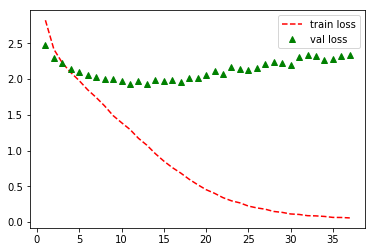

Epoch 38 : [0 / 70]
Epoch 38 : [1 / 70]
Epoch 38 : [2 / 70]
Epoch 38 : [3 / 70]
Epoch 38 : [4 / 70]
Epoch 38 : [5 / 70]
Epoch 38 : [6 / 70]
Epoch 38 : [7 / 70]
Epoch 38 : [8 / 70]
Epoch 38 : [9 / 70]
Epoch 38 : [10 / 70]
Epoch 38 : [11 / 70]
Epoch 38 : [12 / 70]
Epoch 38 : [13 / 70]
Epoch 38 : [14 / 70]
Epoch 38 : [15 / 70]
Epoch 38 : [16 / 70]
Epoch 38 : [17 / 70]
Epoch 38 : [18 / 70]
Epoch 38 : [19 / 70]
Epoch 38 : [20 / 70]
Epoch 38 : [21 / 70]
Epoch 38 : [22 / 70]
Epoch 38 : [23 / 70]
Epoch 38 : [24 / 70]
Epoch 38 : [25 / 70]
Epoch 38 : [26 / 70]
Epoch 38 : [27 / 70]
Epoch 38 : [28 / 70]
Epoch 38 : [29 / 70]
Epoch 38 : [30 / 70]
Epoch 38 : [31 / 70]
Epoch 38 : [32 / 70]
Epoch 38 : [33 / 70]
Epoch 38 : [34 / 70]
Epoch 38 : [35 / 70]
Epoch 38 : [36 / 70]
Epoch 38 : [37 / 70]
Epoch 38 : [38 / 70]
Epoch 38 : [39 / 70]
Epoch 38 : [40 / 70]
Epoch 38 : [41 / 70]
Epoch 38 : [42 / 70]
Epoch 38 : [43 / 70]
Epoch 38 : [44 / 70]
Epoch 38 : [45 / 70]
Epoch 38 : [46 / 70]
Epoch 38 : [47 / 70]
Ep

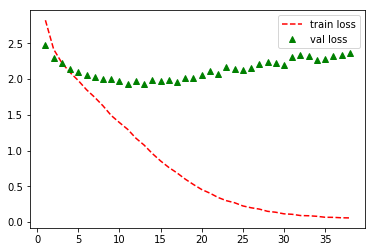

Epoch 39 : [0 / 70]
Epoch 39 : [1 / 70]
Epoch 39 : [2 / 70]
Epoch 39 : [3 / 70]
Epoch 39 : [4 / 70]
Epoch 39 : [5 / 70]
Epoch 39 : [6 / 70]
Epoch 39 : [7 / 70]
Epoch 39 : [8 / 70]
Epoch 39 : [9 / 70]
Epoch 39 : [10 / 70]
Epoch 39 : [11 / 70]
Epoch 39 : [12 / 70]
Epoch 39 : [13 / 70]
Epoch 39 : [14 / 70]
Epoch 39 : [15 / 70]
Epoch 39 : [16 / 70]
Epoch 39 : [17 / 70]
Epoch 39 : [18 / 70]
Epoch 39 : [19 / 70]
Epoch 39 : [20 / 70]
Epoch 39 : [21 / 70]
Epoch 39 : [22 / 70]
Epoch 39 : [23 / 70]
Epoch 39 : [24 / 70]
Epoch 39 : [25 / 70]
Epoch 39 : [26 / 70]
Epoch 39 : [27 / 70]
Epoch 39 : [28 / 70]
Epoch 39 : [29 / 70]
Epoch 39 : [30 / 70]
Epoch 39 : [31 / 70]
Epoch 39 : [32 / 70]
Epoch 39 : [33 / 70]
Epoch 39 : [34 / 70]
Epoch 39 : [35 / 70]
Epoch 39 : [36 / 70]
Epoch 39 : [37 / 70]
Epoch 39 : [38 / 70]
Epoch 39 : [39 / 70]
Epoch 39 : [40 / 70]
Epoch 39 : [41 / 70]
Epoch 39 : [42 / 70]
Epoch 39 : [43 / 70]
Epoch 39 : [44 / 70]
Epoch 39 : [45 / 70]
Epoch 39 : [46 / 70]
Epoch 39 : [47 / 70]
Ep

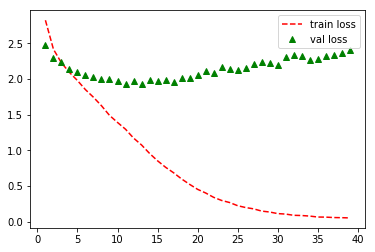

Epoch 40 : [0 / 70]
Epoch 40 : [1 / 70]
Epoch 40 : [2 / 70]
Epoch 40 : [3 / 70]
Epoch 40 : [4 / 70]
Epoch 40 : [5 / 70]
Epoch 40 : [6 / 70]
Epoch 40 : [7 / 70]
Epoch 40 : [8 / 70]
Epoch 40 : [9 / 70]
Epoch 40 : [10 / 70]
Epoch 40 : [11 / 70]
Epoch 40 : [12 / 70]
Epoch 40 : [13 / 70]
Epoch 40 : [14 / 70]
Epoch 40 : [15 / 70]
Epoch 40 : [16 / 70]
Epoch 40 : [17 / 70]
Epoch 40 : [18 / 70]
Epoch 40 : [19 / 70]
Epoch 40 : [20 / 70]
Epoch 40 : [21 / 70]
Epoch 40 : [22 / 70]
Epoch 40 : [23 / 70]
Epoch 40 : [24 / 70]
Epoch 40 : [25 / 70]
Epoch 40 : [26 / 70]
Epoch 40 : [27 / 70]
Epoch 40 : [28 / 70]
Epoch 40 : [29 / 70]
Epoch 40 : [30 / 70]
Epoch 40 : [31 / 70]
Epoch 40 : [32 / 70]
Epoch 40 : [33 / 70]
Epoch 40 : [34 / 70]
Epoch 40 : [35 / 70]
Epoch 40 : [36 / 70]
Epoch 40 : [37 / 70]
Epoch 40 : [38 / 70]
Epoch 40 : [39 / 70]
Epoch 40 : [40 / 70]
Epoch 40 : [41 / 70]
Epoch 40 : [42 / 70]
Epoch 40 : [43 / 70]
Epoch 40 : [44 / 70]
Epoch 40 : [45 / 70]
Epoch 40 : [46 / 70]
Epoch 40 : [47 / 70]
Ep

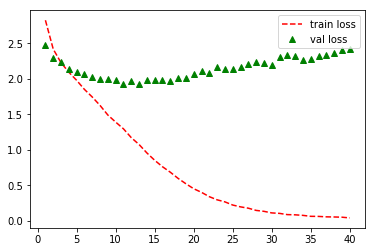

Epoch 41 : [0 / 70]
Epoch 41 : [1 / 70]
Epoch 41 : [2 / 70]
Epoch 41 : [3 / 70]
Epoch 41 : [4 / 70]
Epoch 41 : [5 / 70]
Epoch 41 : [6 / 70]
Epoch 41 : [7 / 70]
Epoch 41 : [8 / 70]
Epoch 41 : [9 / 70]
Epoch 41 : [10 / 70]
Epoch 41 : [11 / 70]
Epoch 41 : [12 / 70]
Epoch 41 : [13 / 70]
Epoch 41 : [14 / 70]
Epoch 41 : [15 / 70]
Epoch 41 : [16 / 70]
Epoch 41 : [17 / 70]
Epoch 41 : [18 / 70]
Epoch 41 : [19 / 70]
Epoch 41 : [20 / 70]
Epoch 41 : [21 / 70]
Epoch 41 : [22 / 70]
Epoch 41 : [23 / 70]
Epoch 41 : [24 / 70]
Epoch 41 : [25 / 70]
Epoch 41 : [26 / 70]
Epoch 41 : [27 / 70]
Epoch 41 : [28 / 70]
Epoch 41 : [29 / 70]
Epoch 41 : [30 / 70]
Epoch 41 : [31 / 70]
Epoch 41 : [32 / 70]
Epoch 41 : [33 / 70]
Epoch 41 : [34 / 70]
Epoch 41 : [35 / 70]
Epoch 41 : [36 / 70]
Epoch 41 : [37 / 70]
Epoch 41 : [38 / 70]
Epoch 41 : [39 / 70]
Epoch 41 : [40 / 70]
Epoch 41 : [41 / 70]
Epoch 41 : [42 / 70]
Epoch 41 : [43 / 70]
Epoch 41 : [44 / 70]
Epoch 41 : [45 / 70]
Epoch 41 : [46 / 70]
Epoch 41 : [47 / 70]
Ep

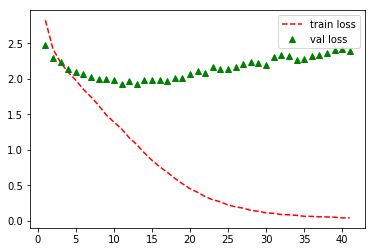

Epoch 42 : [0 / 70]
Epoch 42 : [1 / 70]
Epoch 42 : [2 / 70]
Epoch 42 : [3 / 70]
Epoch 42 : [4 / 70]
Epoch 42 : [5 / 70]
Epoch 42 : [6 / 70]
Epoch 42 : [7 / 70]
Epoch 42 : [8 / 70]
Epoch 42 : [9 / 70]
Epoch 42 : [10 / 70]
Epoch 42 : [11 / 70]
Epoch 42 : [12 / 70]
Epoch 42 : [13 / 70]
Epoch 42 : [14 / 70]
Epoch 42 : [15 / 70]
Epoch 42 : [16 / 70]
Epoch 42 : [17 / 70]
Epoch 42 : [18 / 70]
Epoch 42 : [19 / 70]
Epoch 42 : [20 / 70]
Epoch 42 : [21 / 70]
Epoch 42 : [22 / 70]
Epoch 42 : [23 / 70]
Epoch 42 : [24 / 70]
Epoch 42 : [25 / 70]
Epoch 42 : [26 / 70]
Epoch 42 : [27 / 70]
Epoch 42 : [28 / 70]
Epoch 42 : [29 / 70]
Epoch 42 : [30 / 70]
Epoch 42 : [31 / 70]
Epoch 42 : [32 / 70]
Epoch 42 : [33 / 70]
Epoch 42 : [34 / 70]
Epoch 42 : [35 / 70]
Epoch 42 : [36 / 70]
Epoch 42 : [37 / 70]
Epoch 42 : [38 / 70]
Epoch 42 : [39 / 70]
Epoch 42 : [40 / 70]
Epoch 42 : [41 / 70]
Epoch 42 : [42 / 70]
Epoch 42 : [43 / 70]
Epoch 42 : [44 / 70]
Epoch 42 : [45 / 70]
Epoch 42 : [46 / 70]
Epoch 42 : [47 / 70]
Ep

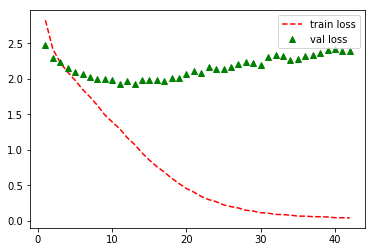

Epoch 43 : [0 / 70]
Epoch 43 : [1 / 70]
Epoch 43 : [2 / 70]
Epoch 43 : [3 / 70]
Epoch 43 : [4 / 70]
Epoch 43 : [5 / 70]
Epoch 43 : [6 / 70]
Epoch 43 : [7 / 70]
Epoch 43 : [8 / 70]
Epoch 43 : [9 / 70]
Epoch 43 : [10 / 70]
Epoch 43 : [11 / 70]
Epoch 43 : [12 / 70]
Epoch 43 : [13 / 70]
Epoch 43 : [14 / 70]
Epoch 43 : [15 / 70]
Epoch 43 : [16 / 70]
Epoch 43 : [17 / 70]
Epoch 43 : [18 / 70]
Epoch 43 : [19 / 70]
Epoch 43 : [20 / 70]
Epoch 43 : [21 / 70]
Epoch 43 : [22 / 70]
Epoch 43 : [23 / 70]
Epoch 43 : [24 / 70]
Epoch 43 : [25 / 70]
Epoch 43 : [26 / 70]
Epoch 43 : [27 / 70]
Epoch 43 : [28 / 70]
Epoch 43 : [29 / 70]
Epoch 43 : [30 / 70]
Epoch 43 : [31 / 70]
Epoch 43 : [32 / 70]
Epoch 43 : [33 / 70]
Epoch 43 : [34 / 70]
Epoch 43 : [35 / 70]
Epoch 43 : [36 / 70]
Epoch 43 : [37 / 70]
Epoch 43 : [38 / 70]
Epoch 43 : [39 / 70]
Epoch 43 : [40 / 70]
Epoch 43 : [41 / 70]
Epoch 43 : [42 / 70]
Epoch 43 : [43 / 70]
Epoch 43 : [44 / 70]
Epoch 43 : [45 / 70]
Epoch 43 : [46 / 70]
Epoch 43 : [47 / 70]
Ep

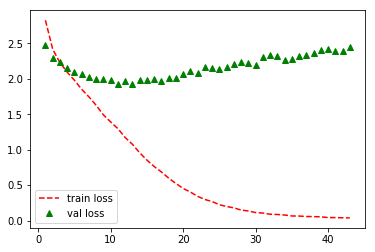

Epoch 44 : [0 / 70]
Epoch 44 : [1 / 70]
Epoch 44 : [2 / 70]
Epoch 44 : [3 / 70]
Epoch 44 : [4 / 70]
Epoch 44 : [5 / 70]
Epoch 44 : [6 / 70]
Epoch 44 : [7 / 70]
Epoch 44 : [8 / 70]
Epoch 44 : [9 / 70]
Epoch 44 : [10 / 70]
Epoch 44 : [11 / 70]
Epoch 44 : [12 / 70]
Epoch 44 : [13 / 70]
Epoch 44 : [14 / 70]
Epoch 44 : [15 / 70]
Epoch 44 : [16 / 70]
Epoch 44 : [17 / 70]
Epoch 44 : [18 / 70]
Epoch 44 : [19 / 70]
Epoch 44 : [20 / 70]
Epoch 44 : [21 / 70]
Epoch 44 : [22 / 70]
Epoch 44 : [23 / 70]
Epoch 44 : [24 / 70]
Epoch 44 : [25 / 70]
Epoch 44 : [26 / 70]
Epoch 44 : [27 / 70]
Epoch 44 : [28 / 70]
Epoch 44 : [29 / 70]
Epoch 44 : [30 / 70]
Epoch 44 : [31 / 70]
Epoch 44 : [32 / 70]
Epoch 44 : [33 / 70]
Epoch 44 : [34 / 70]
Epoch 44 : [35 / 70]
Epoch 44 : [36 / 70]
Epoch 44 : [37 / 70]
Epoch 44 : [38 / 70]
Epoch 44 : [39 / 70]
Epoch 44 : [40 / 70]
Epoch 44 : [41 / 70]
Epoch 44 : [42 / 70]
Epoch 44 : [43 / 70]
Epoch 44 : [44 / 70]
Epoch 44 : [45 / 70]
Epoch 44 : [46 / 70]
Epoch 44 : [47 / 70]
Ep

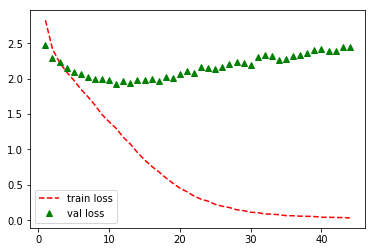

Epoch 45 : [0 / 70]
Epoch 45 : [1 / 70]
Epoch 45 : [2 / 70]
Epoch 45 : [3 / 70]
Epoch 45 : [4 / 70]
Epoch 45 : [5 / 70]
Epoch 45 : [6 / 70]
Epoch 45 : [7 / 70]
Epoch 45 : [8 / 70]
Epoch 45 : [9 / 70]
Epoch 45 : [10 / 70]
Epoch 45 : [11 / 70]
Epoch 45 : [12 / 70]
Epoch 45 : [13 / 70]
Epoch 45 : [14 / 70]
Epoch 45 : [15 / 70]
Epoch 45 : [16 / 70]
Epoch 45 : [17 / 70]
Epoch 45 : [18 / 70]
Epoch 45 : [19 / 70]
Epoch 45 : [20 / 70]
Epoch 45 : [21 / 70]
Epoch 45 : [22 / 70]
Epoch 45 : [23 / 70]
Epoch 45 : [24 / 70]
Epoch 45 : [25 / 70]
Epoch 45 : [26 / 70]
Epoch 45 : [27 / 70]
Epoch 45 : [28 / 70]
Epoch 45 : [29 / 70]
Epoch 45 : [30 / 70]
Epoch 45 : [31 / 70]
Epoch 45 : [32 / 70]
Epoch 45 : [33 / 70]
Epoch 45 : [34 / 70]
Epoch 45 : [35 / 70]
Epoch 45 : [36 / 70]
Epoch 45 : [37 / 70]
Epoch 45 : [38 / 70]
Epoch 45 : [39 / 70]
Epoch 45 : [40 / 70]
Epoch 45 : [41 / 70]
Epoch 45 : [42 / 70]
Epoch 45 : [43 / 70]
Epoch 45 : [44 / 70]
Epoch 45 : [45 / 70]
Epoch 45 : [46 / 70]
Epoch 45 : [47 / 70]
Ep

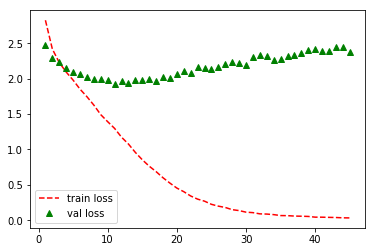

Epoch 46 : [0 / 70]
Epoch 46 : [1 / 70]
Epoch 46 : [2 / 70]
Epoch 46 : [3 / 70]
Epoch 46 : [4 / 70]
Epoch 46 : [5 / 70]
Epoch 46 : [6 / 70]
Epoch 46 : [7 / 70]
Epoch 46 : [8 / 70]
Epoch 46 : [9 / 70]
Epoch 46 : [10 / 70]
Epoch 46 : [11 / 70]
Epoch 46 : [12 / 70]
Epoch 46 : [13 / 70]
Epoch 46 : [14 / 70]
Epoch 46 : [15 / 70]
Epoch 46 : [16 / 70]
Epoch 46 : [17 / 70]
Epoch 46 : [18 / 70]
Epoch 46 : [19 / 70]
Epoch 46 : [20 / 70]
Epoch 46 : [21 / 70]
Epoch 46 : [22 / 70]
Epoch 46 : [23 / 70]
Epoch 46 : [24 / 70]
Epoch 46 : [25 / 70]
Epoch 46 : [26 / 70]
Epoch 46 : [27 / 70]
Epoch 46 : [28 / 70]
Epoch 46 : [29 / 70]
Epoch 46 : [30 / 70]
Epoch 46 : [31 / 70]
Epoch 46 : [32 / 70]
Epoch 46 : [33 / 70]
Epoch 46 : [34 / 70]
Epoch 46 : [35 / 70]
Epoch 46 : [36 / 70]
Epoch 46 : [37 / 70]
Epoch 46 : [38 / 70]
Epoch 46 : [39 / 70]
Epoch 46 : [40 / 70]
Epoch 46 : [41 / 70]
Epoch 46 : [42 / 70]
Epoch 46 : [43 / 70]
Epoch 46 : [44 / 70]
Epoch 46 : [45 / 70]
Epoch 46 : [46 / 70]
Epoch 46 : [47 / 70]
Ep

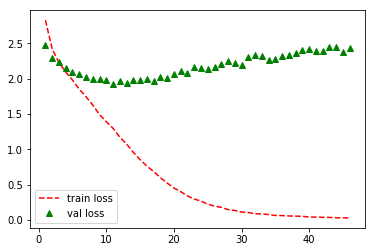

Epoch 47 : [0 / 70]
Epoch 47 : [1 / 70]
Epoch 47 : [2 / 70]
Epoch 47 : [3 / 70]
Epoch 47 : [4 / 70]
Epoch 47 : [5 / 70]
Epoch 47 : [6 / 70]
Epoch 47 : [7 / 70]
Epoch 47 : [8 / 70]
Epoch 47 : [9 / 70]
Epoch 47 : [10 / 70]
Epoch 47 : [11 / 70]
Epoch 47 : [12 / 70]
Epoch 47 : [13 / 70]
Epoch 47 : [14 / 70]
Epoch 47 : [15 / 70]
Epoch 47 : [16 / 70]
Epoch 47 : [17 / 70]
Epoch 47 : [18 / 70]
Epoch 47 : [19 / 70]
Epoch 47 : [20 / 70]
Epoch 47 : [21 / 70]
Epoch 47 : [22 / 70]
Epoch 47 : [23 / 70]
Epoch 47 : [24 / 70]
Epoch 47 : [25 / 70]
Epoch 47 : [26 / 70]
Epoch 47 : [27 / 70]
Epoch 47 : [28 / 70]
Epoch 47 : [29 / 70]
Epoch 47 : [30 / 70]
Epoch 47 : [31 / 70]
Epoch 47 : [32 / 70]
Epoch 47 : [33 / 70]
Epoch 47 : [34 / 70]
Epoch 47 : [35 / 70]
Epoch 47 : [36 / 70]
Epoch 47 : [37 / 70]
Epoch 47 : [38 / 70]
Epoch 47 : [39 / 70]
Epoch 47 : [40 / 70]
Epoch 47 : [41 / 70]
Epoch 47 : [42 / 70]
Epoch 47 : [43 / 70]
Epoch 47 : [44 / 70]
Epoch 47 : [45 / 70]
Epoch 47 : [46 / 70]
Epoch 47 : [47 / 70]
Ep

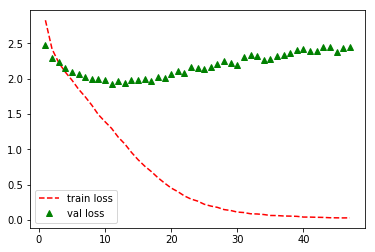

Epoch 48 : [0 / 70]
Epoch 48 : [1 / 70]
Epoch 48 : [2 / 70]
Epoch 48 : [3 / 70]
Epoch 48 : [4 / 70]
Epoch 48 : [5 / 70]
Epoch 48 : [6 / 70]
Epoch 48 : [7 / 70]
Epoch 48 : [8 / 70]
Epoch 48 : [9 / 70]
Epoch 48 : [10 / 70]
Epoch 48 : [11 / 70]
Epoch 48 : [12 / 70]
Epoch 48 : [13 / 70]
Epoch 48 : [14 / 70]
Epoch 48 : [15 / 70]
Epoch 48 : [16 / 70]
Epoch 48 : [17 / 70]
Epoch 48 : [18 / 70]
Epoch 48 : [19 / 70]
Epoch 48 : [20 / 70]
Epoch 48 : [21 / 70]
Epoch 48 : [22 / 70]
Epoch 48 : [23 / 70]
Epoch 48 : [24 / 70]
Epoch 48 : [25 / 70]
Epoch 48 : [26 / 70]
Epoch 48 : [27 / 70]
Epoch 48 : [28 / 70]
Epoch 48 : [29 / 70]
Epoch 48 : [30 / 70]
Epoch 48 : [31 / 70]
Epoch 48 : [32 / 70]
Epoch 48 : [33 / 70]
Epoch 48 : [34 / 70]
Epoch 48 : [35 / 70]
Epoch 48 : [36 / 70]
Epoch 48 : [37 / 70]
Epoch 48 : [38 / 70]
Epoch 48 : [39 / 70]
Epoch 48 : [40 / 70]
Epoch 48 : [41 / 70]
Epoch 48 : [42 / 70]
Epoch 48 : [43 / 70]
Epoch 48 : [44 / 70]
Epoch 48 : [45 / 70]
Epoch 48 : [46 / 70]
Epoch 48 : [47 / 70]
Ep

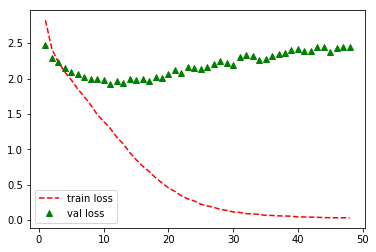

Epoch 49 : [0 / 70]
Epoch 49 : [1 / 70]
Epoch 49 : [2 / 70]
Epoch 49 : [3 / 70]
Epoch 49 : [4 / 70]
Epoch 49 : [5 / 70]
Epoch 49 : [6 / 70]
Epoch 49 : [7 / 70]
Epoch 49 : [8 / 70]
Epoch 49 : [9 / 70]
Epoch 49 : [10 / 70]
Epoch 49 : [11 / 70]
Epoch 49 : [12 / 70]
Epoch 49 : [13 / 70]
Epoch 49 : [14 / 70]
Epoch 49 : [15 / 70]
Epoch 49 : [16 / 70]
Epoch 49 : [17 / 70]
Epoch 49 : [18 / 70]
Epoch 49 : [19 / 70]
Epoch 49 : [20 / 70]
Epoch 49 : [21 / 70]
Epoch 49 : [22 / 70]
Epoch 49 : [23 / 70]
Epoch 49 : [24 / 70]
Epoch 49 : [25 / 70]
Epoch 49 : [26 / 70]
Epoch 49 : [27 / 70]
Epoch 49 : [28 / 70]
Epoch 49 : [29 / 70]
Epoch 49 : [30 / 70]
Epoch 49 : [31 / 70]
Epoch 49 : [32 / 70]
Epoch 49 : [33 / 70]
Epoch 49 : [34 / 70]
Epoch 49 : [35 / 70]
Epoch 49 : [36 / 70]
Epoch 49 : [37 / 70]
Epoch 49 : [38 / 70]
Epoch 49 : [39 / 70]
Epoch 49 : [40 / 70]
Epoch 49 : [41 / 70]
Epoch 49 : [42 / 70]
Epoch 49 : [43 / 70]
Epoch 49 : [44 / 70]
Epoch 49 : [45 / 70]
Epoch 49 : [46 / 70]
Epoch 49 : [47 / 70]
Ep

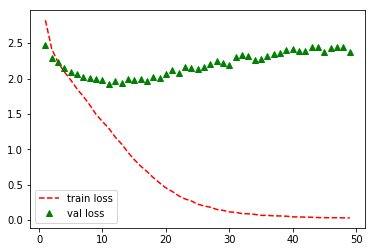

In [13]:
train_loss = []
val_loss = []
for epoch_num in range(1, 50):
    epoch_train_loss, epoch_val_loss = train(model, criterion, train_loader, val_loader, optimizer, epoch_num, bs)
    train_loss.append(epoch_train_loss)
    val_loss.append(epoch_val_loss)
    epoch_completed = np.arange(1, epoch_num+1)
    fig, ax = plt.subplots()
    ax.plot(epoch_completed, train_loss, 'r--', label='train loss')
    ax.plot(epoch_completed, val_loss, 'g^', label='val loss')
    ax.legend()
    plt.show()
    if epoch_num%5 == 0:
        torch.save(model.state_dict(), 'gdrive/My Drive/checkpoint{}.pth'.format(epoch_num))